In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import seaborn as sns

from alive_progress import alive_bar

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit

from astropy.time import Time
import astropy.units as u

from functools import lru_cache

from datetime import datetime

import ssa_calc

# # Defining plotting style:
plt.style.use("default")  # Dark background for plots

mpl.rcParams["grid.color"] = "grey"  # Grid color
mpl.rcParams["grid.linestyle"] = "--"  # Grid line style
mpl.rcParams["grid.linewidth"] = 0.5  # Grid line width
mpl.rcParams["grid.alpha"] = 0.5  # Grid transparency

# Setting plt colors:
# Setting plt colors to TU Delft colors (order: blue, red, yellow, green and repeating with different shades):
plt_colors = [
    "#006EB7",
    '#A50034',
    "#64A600",
    "#F97306",
    # Darker colors
    '#1A356E',
    "#E60000",
    '#6CC24A',
    '#FFB81C',
    # More darker colors
    "#000D3A",
    "#9A0000",
    "#B14400",
    "#3D5B00",
]

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set random seed for reproducibility:
np.random.seed(42)
tf.random.set_seed(42)

Num GPUs Available:  1


In [2]:
# Loading the data
telem_path = r"../telemetry-files/delfi-pq/delfi-pq-telemetry-2022-01-18-to-2023-02-01.h5"
telem_df = pd.read_hdf(
    telem_path,
    "telem",
)

# Adding illumination to the dataframe:
for i, row in telem_df.iterrows():
    telem_df.loc[i, "illumination"] = 1 if row["theta_T (deg)"] < 360 * (1 - row["fe"]) else 0

telem_df["illumination"] = telem_df["illumination"].astype(np.int64)
# Rearranging illumination column to be after theta_T (deg):
cols = telem_df.columns.tolist()
cols = cols[:6] + cols[-1:] + cols[6:-1]
telem_df = telem_df[cols]
telem_df.head()

time (utc)     time (jd)  beta (deg)        fe  theta (deg)  \
0  2022-01-18 17:12:17.000  2.459598e+06   32.895989  0.349273   220.506984   
1  2022-01-18 18:41:24.000  2.459598e+06   32.900397  0.349014   197.714357   
2  2022-01-18 18:43:24.000  2.459598e+06   32.901143  0.349090   205.275916   
3  2022-01-18 18:44:24.000  2.459598e+06   32.901391  0.349131   209.056697   
4  2022-01-18 18:45:24.000  2.459598e+06   32.901552  0.349173   212.837490   

   theta_T (deg)  illumination  battery GG temperature (deg C)  \
0     337.637846             0                            -4.2   
1     314.891798             0                            -0.7   
2     322.439748             0                            -1.9   
3     326.213181             0                            -2.4   
4     329.986271             0                            -3.0   

   battery TMP20 temperature (deg C)  solar panel Yp temperature (deg C)  \
0                               -3.2                               -24.7   
1                                0.8                               -18.5   
2                                0.0                               -20.9   
3                               -0.2                               -21.9   
4                               -1.3                               -23.0   

   solar panel Ym temperature (deg C)  solar panel Xp temperature (deg C)  \
0                               -26.4                               -25.0   
1                               -20.7                               -18.6   
2                               -22.7                               -20.8   
3                               -23.8                               -22.1   
4                               -24.9                               -23.2   

   solar panel Xm temperature (deg C)  MCU temperature (deg C)  
0                               -23.4                    -12.2  
1                               -17.8                     -7.4  
2                               -19.9                     -8.9  
3                               -20.9                     -9.8  
4                               -21.9                    -11.2

In [3]:
def normalize_temperature(temps, limits=None):
    """
    Function to normalize the temperature data to the range [0, 1].
    :param temps: Temperature data to be normalized.
    :param limits: Limits of the temperature data. If None, the limits are calculated from the data.

    :return: Normalized temperature data.
    """
    
    if limits is None:
        limits = np.array([np.min(temps), np.max(temps)])

    return (temps - limits[0]) / (limits[1] - limits[0])

def denormalize_temperature(temps, limits):
    """
    Function to denormalize the temperature data to the range [0, 1].
    :param temps: Temperature data to be denormalized.
    :param limits: Limits of the temperature data.

    :return: Denormalized temperature data.
    """

    return temps * (limits[1] - limits[0]) + limits[0]

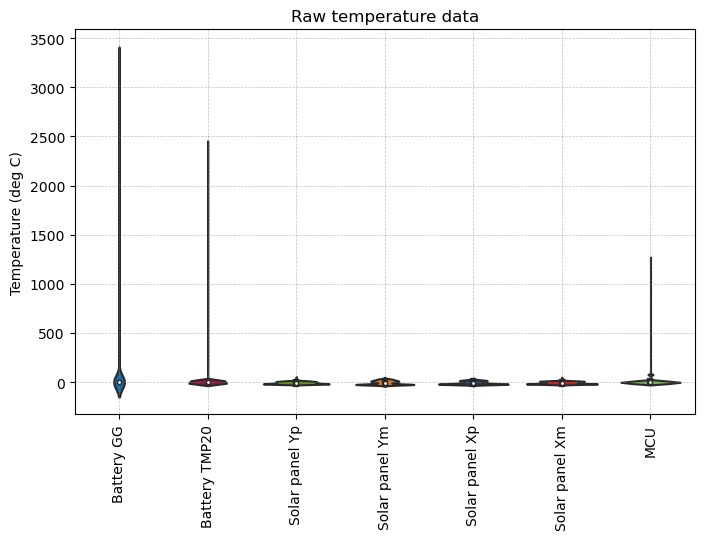

In [4]:
# Plotting the temperature data in a violin plot:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.violinplot(
    data=telem_df.loc[:, "battery GG temperature (deg C)":"MCU temperature (deg C)"],
    palette=plt_colors,
    ax=ax,
)
ax.set_xticklabels(
    [
        "Battery GG",
        "Battery TMP20",
        "Solar panel Yp",
        "Solar panel Ym",
        "Solar panel Xp",
        "Solar panel Xm",
        "MCU",
    ],
    rotation=90,
    ha="center",
)
ax.set_ylabel("Temperature (deg C)")
ax.set_title("Raw temperature data")
ax.grid()
plt.show()

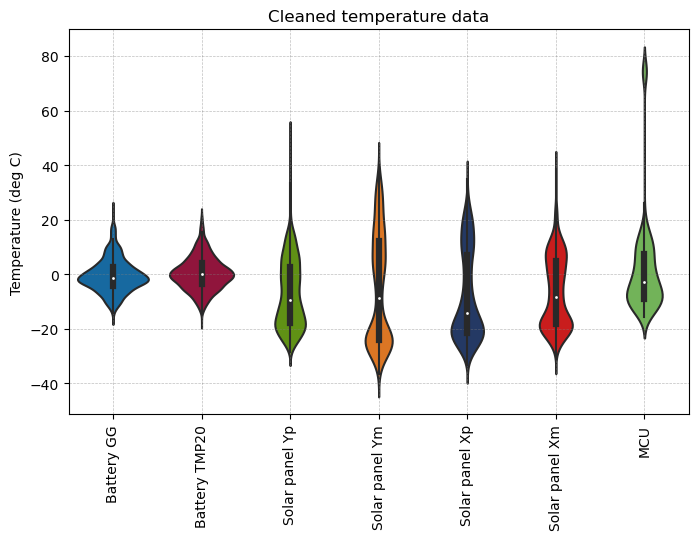

In [5]:
# Cleaning the data:
telem_processed_df = telem_df.copy()

for i, row in telem_processed_df.iterrows():
    # Removing temperature if > 200 deg C:
    for j, temp in row.iloc[6:].items():
        if temp > 200:
            telem_processed_df.loc[i, j] = np.nan

telem_processed_df = telem_processed_df.dropna(how="all").reset_index(drop=True)

# Plotting the temperature data in a violin plot:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.violinplot(
    data=telem_processed_df.loc[:, "battery GG temperature (deg C)":"MCU temperature (deg C)"],
    palette=plt_colors,
    ax=ax,
)
ax.set_xticklabels(
    [
        "Battery GG",
        "Battery TMP20",
        "Solar panel Yp",
        "Solar panel Ym",
        "Solar panel Xp",
        "Solar panel Xm",
        "MCU",
    ],
    rotation=90,
    ha="center",
)
ax.set_ylabel("Temperature (deg C)")
ax.set_title("Cleaned temperature data")
ax.grid()
plt.show()


In [6]:
def plot_model(theta_T_vals, temp_vals, plt_titles=None, labels=None, colors=None, plt_scatter=None, linestyles=None, limits=None, plt_suptitle=None):
    """
    Function to plot the temperatures vs. theta_T.
    :param theta_T_vals: theta_T values.
    :param temp_vals: Temperature values.
    :param plt_titles: Titles of the plots.
    :param labels: Labels of the plots.
    :param colors: Colors of the plots.
    :param plt_scatter: Whether to plot the data as a scatter plot or not.
    :param linestyles: Linestyles of the plots.
    :param limits: Limits of the temperature data.

    :return: None
    """
    plt_rows = 2
    plt_cols = 3
    
    fig, ax = plt.subplots(plt_rows, plt_cols, figsize=(plt_cols * 5, plt_rows * 5))

    for i in range(plt_rows):
        for j in range(plt_cols):
            for k in range(len(theta_T_vals)):
                if plt_scatter[k]:
                    ax[i, j].scatter(
                        theta_T_vals[k],
                        temp_vals[k][:, i * plt_cols + j],
                        label=labels[k] if labels is not None else None,
                        color=colors[k] if colors is not None else plt_colors[k],
                        s=2,
                    )
                else:
                    ax[i, j].plot(
                        theta_T_vals[k],
                        temp_vals[k][:, i * plt_cols + j],
                        label=labels[k] if labels is not None else None,
                        color=colors[k] if colors is not None else plt_colors[k],
                        linestyle=linestyles[k] if linestyles is not None else "-",
                    )
            
            ax[i, j].set_xlabel(r"$\theta_T$ (deg)")
            ax[i, j].set_ylabel("Temperature (deg C)")
            ax[i, j].set_title(plt_titles[i * plt_cols + j] if plt_titles is not None else None)
            ax[i, j].legend(fontsize=8)
            ax[i, j].set_xlim([0, 360])
            if limits is not None:
                ax[i, j].set_ylim(limits)
            ax[i, j].grid()

    if plt_suptitle is not None:
        fig.suptitle(plt_suptitle, fontsize=12)

In [7]:
# Splitting the data into training and testing sets
train_df = telem_processed_df[:int(0.8 * len(telem_processed_df))].copy()
test_df = telem_processed_df[int(
    0.8 * len(telem_processed_df)):].copy().reset_index(drop=True)

# Normalizing the data
norm_limits = np.array([np.nanmin(train_df.iloc[:, 8:].to_numpy()), np.nanmax(train_df.iloc[:, 8:].to_numpy())])  # limits of the temperature data calculated only from the training data

train_norm_df = train_df.copy() # copying the training data to a new dataframe
test_norm_df = test_df.copy()   # copying the testing data to a new dataframe

train_norm_df.iloc[:, 8:] = normalize_temperature(train_norm_df.iloc[:, 8:].to_numpy(), norm_limits) # normalizing the training data
test_norm_df.iloc[:, 8:] = normalize_temperature(test_norm_df.iloc[:, 8:].to_numpy(), norm_limits)  # normalizing the testing data

In [8]:
# Offloading beta, fe, theta, theta_T calculation to a cached function for increased performance
@lru_cache(maxsize=500)
def get_beta_fe_theta(satellite, time):
    """
    Function to calculate beta, fe, theta, theta_T for a given satellite and time.
    :param satellite: Satellite name.
    :param time: Time of the observation.

    :return: beta, fe, theta, theta_T
    """
    return satellite.calc_beta_fe_theta(time)



def window_data_base(df, window_size, satellite, return_numpy=True):
    """
    Function to create windowed data for the base model.
    :param df: Dataframe to be windowed.
    :param window_size: Size of the window.
    :param return_numpy: Boolean to return the input and output numpy arrays of the model.
    :param check_continuity: Boolean to check for continuity in the data.

    :return: Windowed dataframe (and) numpy arrays of the input and output data.
    """


    columns = np.concatenate((
        ["time (jd)"],
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["battery temp"],
        ["solar panel Yp temp"],
        ["solar panel Ym temp"],
        ["solar panel Xp temp"],
        ["solar panel Xm temp"],
        ["MCU temp"],
    ))  # columns of the windowed dataframe

    window_df = pd.DataFrame(
        columns=columns, index=range(len(df)))
    with alive_bar(len(df), theme="classic", title="Windowing data", force_tty=True) as bar:
        for i in range(len(window_df)):
            window_df.iloc[i, 0] = df["time (jd)"][i]  # time value of the output
            window_df.iloc[i, 1] = df["theta_T (deg)"][i] # theta_T value of the output
            # Calculating the illumination values
            time = Time(df["time (utc)"][i])
            for j in range(window_size, 0, -1):
                beta, fe, theta, theta_T = get_beta_fe_theta(satellite, time - j * u.min)
                window_df.iloc[i, window_size - j + 2] = 1 if theta_T < 2 * np.pi * (1 - fe) * u.rad else 0
            window_df.iloc[i, window_size + 2:] = df.iloc[i, 8:]  # temperature values of the output 
            bar()

    window_df = window_df.dropna().reset_index(drop=True)  # dropping the rows with NaN values


    if return_numpy:
        # Creating the numpy arrays
        x_data = np.empty(
            shape=(len(window_df), window_size, 1), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 6), dtype=np.float64)

        for i, row in window_df.iterrows():
            x_data[i, :, 0] = row.iloc[2:window_size + 2]   # input illumination values
            y_data[i, :] = row.iloc[window_size + 2:]   # output temperature values (normalized)

        return window_df, x_data, y_data

    return window_df

In [9]:
# Function to calculate the kernel density estimate (KDE) of a given dataset:
def kde(data, bins=250, plot_kde=True, labels=None, plt_title=None):
    """
    Function to calculate the kernel density estimate (KDE) of a given dataset.
    :param data: Dataset to be used for the KDE.
    :param bins: Number of bins to be used for the KDE.
    :param plot_kde: Boolean to plot the KDE.
    :param labels: Labels of the KDE plots.

    :return: kde, bin_centers
    """

    kde = np.empty(shape=(data.shape[1], bins), dtype=np.float64)   # array to store the KDE values
    bin_centers = np.empty(shape=(data.shape[1], bins), dtype=np.float64)   # array to store the bin centers
    for i in range(data.shape[1]):
        kde_func = gaussian_kde(data[:, i])  # kernel density estimate function
        bin_centers[i] = np.linspace(np.min(data[:, i]), np.max(data[:, i]), bins)  # bin centers
        kde[i, :] = kde_func(bin_centers[i])    # KDE values

    if plot_kde:
        plt.figure(figsize=(5, 5))
        for i in range(data.shape[1]):
            plt.plot(
                bin_centers[i],
                kde[i],
                color=plt_colors[i],
                label=labels[i] if labels is not None else None,
            )

        plt.xlabel(r"Error ($^\circ$C)")
        plt.ylabel(r"Probability density ($^\circ$C$^{-1}$)")
        if plt_title is None:
            plt_title = "Kernel density estimate of the errors"
        plt.title(plt_title)
        plt.legend()
        plt.grid()
        plt.show()

    return kde, bin_centers



def print_kde_stats(data, kde, bin_centers):
    """
    Function to print the mean, standard deviation and area under the KDE curve of a given dataset.
    :param data: Dataset to be used for the KDE.
    :param kde: KDE values.
    :param bin_centers: Bin centers.

    :return: None
    """

    print("Battery:")
    print(f"Mean: {np.mean(data[:, 0]):.2f} degC Std: {np.std(data[:, 0]):.2f} degC (area: {np.trapz(kde[0], bin_centers[0]):.2f})")
    print("Solar panel Yp:")
    print(f"Mean: {np.mean(data[:, 1]):.2f} degC Std: {np.std(data[:, 1]):.2f} degC (area: {np.trapz(kde[1], bin_centers[1]):.2f})")
    print("Solar panel Ym:")
    print(f"Mean: {np.mean(data[:, 2]):.2f} degC Std: {np.std(data[:, 2]):.2f} degC (area: {np.trapz(kde[2], bin_centers[2]):.2f})")
    print("Solar panel Xp:")
    print(f"Mean: {np.mean(data[:, 3]):.2f} degC Std: {np.std(data[:, 3]):.2f} degC (area: {np.trapz(kde[3], bin_centers[3]):.2f})")
    print("Solar panel Xm:")
    print(f"Mean: {np.mean(data[:, 4]):.2f} degC Std: {np.std(data[:, 4]):.2f} degC (area: {np.trapz(kde[4], bin_centers[4]):.2f})")
    print("MCU:")
    print(f"Mean: {np.mean(data[:, 5]):.2f} degC Std: {np.std(data[:, 5]):.2f} degC (area: {np.trapz(kde[5], bin_centers[5]):.2f})")




In [10]:
class Model:
    """
    Class to hold the model and its training and testing data.

    :param train_x: Training input data.
    :param train_y: Training output data.
    :param test_x: Testing input data.
    :param test_y: Testing output data.
    :param name: Name of the model.
    :param model: Tensorflow model.
    :param run_device: Device to run the model on.
    :param history: History of the model training.
    """

    def __init__(self, train_x, train_y, test_x, test_y, name=None):
        """
        Initialize the model class.
        :param train_x: Training input data.
        :param train_y: Training output data.
        :param test_x: Testing input data.
        :param test_y: Testing output data.
        :param name: Name of the model.

        :return: None
        """

        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.name = name
        self.model = None
        self.run_device = None
        self.history = None


    def create_model(self, layers, optimizer, loss, metrics, input_shape, output_shape):
        """
        Create the model.
        :param layers: List of layers stored as dictionaries with the following keys: type, units, activation.
        :param optimizer: Optimizer function to use for trining.
        :param loss: Loss function to use for training.
        :param metrics: Metrics to use for training.
        :param input_shape: Shape of the input data.
        :param output_shape: Shape of the output data.

        :return: None
        """

        self.model = tf.keras.Sequential(name=self.name)    # create the model
        self.model.add(tf.keras.layers.InputLayer(input_shape=input_shape))   # add the input layer
        self.run_device = "/GPU:0"  # set the device to run the model on

        # Add the layers to the model
        for i, layer in enumerate(layers):
            if layer.get("type") == "LSTM":
                if i < len(layers) - 1:
                    if layers[i + 1].get("type") == "LSTM":
                        self.model.add(
                            tf.keras.layers.LSTM(
                                layer.get("units"),
                                activation=layer.get("activation"),
                                return_sequences=True,
                            )
                        )
                    else:
                        self.model.add(
                            tf.keras.layers.LSTM(
                                layer.get("units"),
                                activation=layer.get("activation"),
                                return_sequences=False,
                            )
                        )
                else:
                    self.model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=False,
                        )
                    )
                if layer.get("activation") == "relu":
                    self.run_device = "/CPU:0"  # if the model uses a ReLU activation function, run it on the CPU
            elif layer.get("type") == "Dense":
                self.model.add(
                    tf.keras.layers.Dense(
                        layer.get("units"), activation=layer.get("activation"),
                    )
                )
            else:
                raise ValueError("Invalid layer type")  # raise an error if the layer type is invalid

        self.model.add(tf.keras.layers.Dense(output_shape, activation="linear"))    # add the output layer

        # Compile the model
        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=[metrics],
        )

    
    def train_model(self, epochs, callbacks=None, batch_size=100):
        """
        Function to train the model.
        :param epochs: Number of epochs to train the model for.
        :param callbacks: Callbacks to use during training.

        :return: None
        """
        if self.test_x is None or self.test_y is None:
            monitor_val_loss = False
        else:
            monitor_val_loss = True
        # Train the model
        with tf.device(self.run_device):
            if monitor_val_loss:
                self.history = self.model.fit(
                    self.train_x,
                    self.train_y,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(self.test_x, self.test_y),
                    callbacks=[callbacks],
                )
            else:
                self.history = self.model.fit(
                    self.train_x,
                    self.train_y,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[callbacks],
                )

        # Plot the training history
        plt.figure(figsize=(5, 5))
        plt.plot(
            np.linspace(1, len(self.history.history["loss"]), len(self.history.history["loss"])),
            self.history.history["loss"],
            color=plt_colors[0],
            label="Training Loss",
        )
        if monitor_val_loss:
            plt.plot(
                np.linspace(1, len(self.history.history["loss"]), len(self.history.history["loss"])),
                self.history.history["val_loss"],
                color=plt_colors[1],
                label="Validation Loss",
            )
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(self.name)
        plt.legend()
        plt.grid()
        plt.show()

In [11]:
base_model_layers = np.empty(shape=(7), dtype=dict,)    # create an array to hold the layers of the base model
base_model_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
base_model_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
base_model_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
base_model_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
base_model_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
base_model_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
base_model_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

In [12]:
# Creating the Satellite object
POS_INTERP_PATH = r"../orbit-propagation/interpolators/delfi-pq-pos-interpolator-2022-01-18-to-2023-02-05.pkl"
VEL_INTERP_PATH = r"../orbit-propagation/interpolators/delfi-pq-vel-interpolator-2022-01-18-to-2023-02-05.pkl"
delfi_pq = ssa_calc.Satellite(POS_INTERP_PATH, VEL_INTERP_PATH)

Loading interpolators from pickle files...
Interpolators loaded.


In [13]:
# # Windowing the data
# print("Training data:")
# base_train_df, base_train_x, base_train_y = window_data_base(train_norm_df, 97, delfi_pq)   # create the training data for the base model
# print("Testing data:")
# base_test_df, base_test_x, base_test_y = window_data_base(test_norm_df, 97, delfi_pq) # create the testing data for the base model

# # Cleaning the data
# for i, row in base_train_df.iterrows():
#     if 200 < row.iloc[1] < 300:
#         base_train_df.loc[i, :] = np.nan
#         continue
#     for temp in row.iloc[-6:].values:
#         if temp > normalize_temperature(50, norm_limits):
#             base_train_df.loc[i, :] = np.nan
#             break

# base_train_df = base_train_df.dropna()
# base_train_x = base_train_x[base_train_df.index]
# base_train_y = base_train_y[base_train_df.index]

# for i, row in base_test_df.iterrows():
#     if 200 < row.iloc[1] < 300:
#         base_test_df.loc[i, :] = np.nan
#         continue
#     for temp in row.iloc[-6:].values:
#         if temp > normalize_temperature(50, norm_limits):
#             base_test_df.loc[i, :] = np.nan
#             break

# base_test_df = base_test_df.dropna()
# base_test_x = base_test_x[base_test_df.index]
# base_test_y = base_test_y[base_test_df.index]

# # Saving the training and testing data
# # Converting the datatypes of all columns to np.float64
# base_train_df = base_train_df.astype(np.float64).reset_index(drop=True)
# base_test_df = base_test_df.astype(np.float64).reset_index(drop=True)

# base_train_df.to_hdf("base-df.h5", key="train", mode="w")
# base_test_df.to_hdf("base-df.h5", key="test", mode="a")


In [14]:
# Loading the training and testing data
base_train_df = pd.read_hdf("base-df.h5", key="train")
base_test_df = pd.read_hdf("base-df.h5", key="test")

base_train_x = np.empty(shape=(len(base_train_df), 97, 1), dtype=np.float64)
base_train_y = np.empty(shape=(len(base_train_df), 6), dtype=np.float64)

for i, row in base_train_df.iterrows():
    base_train_x[i, :, 0] = row.iloc[2:99]   # input illumination values
    base_train_y[i, :] = row.iloc[99:]   # output temperature values (normalized)

base_test_x = np.empty(shape=(len(base_test_df), 97, 1), dtype=np.float64)
base_test_y = np.empty(shape=(len(base_test_df), 6), dtype=np.float64)

for i, row in base_test_df.iterrows():
    base_test_x[i, :, 0] = row.iloc[2:99]   # input illumination values
    base_test_y[i, :] = row.iloc[99:]   # output temperature values (normalized)

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         264192    
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         525312    
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         197120    
                                                                 
 lstm_3 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_5 (LSTM)               (None, None, 32)          12416     
                                                                 
 lstm_6 (LSTM)               (None, 16)                3

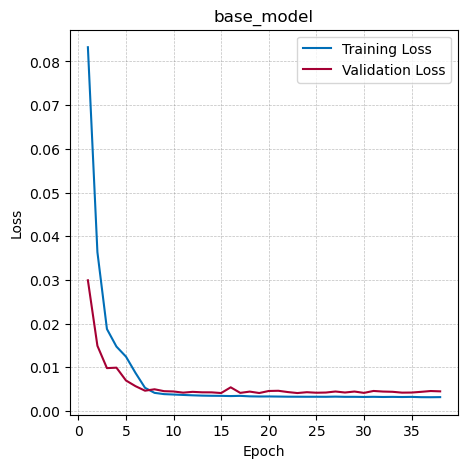

In [15]:
base_model = Model(
    base_train_x,
    base_train_y,
    base_test_x,
    base_test_y,
    name="base_model",
)   # initialize the base model

base_model.create_model(
    base_model_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=(None, 1),
    output_shape=6,
)   # create the base model

base_model.model.summary()

# Getting the initial weights of the base model
base_model_weights = base_model.model.get_weights()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
)   # create an early stopping callback

base_model.train_model(250, early_stopping, batch_size=100)   # train the base model

In [16]:
# Creating illumination data for a full orbit:
start_time = Time("2022-01-27 18:33:00", format="iso", scale="utc") - 97 * u.min

theta_T_list = []
illumination_list = []

with alive_bar(97+94, theme="classic", title="Creating illumination data", force_tty=True) as bar:
    for i in range(97+94):
        time = start_time + i * u.min
        beta, fe, theta, theta_T = delfi_pq.calc_beta_fe_theta(time)
        theta_T_list.append(theta_T.to(u.deg).value)
        illumination_list.append(1 if theta_T < 2 * np.pi * (1 - fe) * u.rad else 0)
        bar()

# Creating test x and y data for the base model
artificial_test_x = np.empty(shape=(94, 97, 1), dtype=np.float64)

for i in range(94):
    artificial_test_x[i, :, 0] = illumination_list[i:97+i]

artificial_test_y = base_model.model.predict(artificial_test_x)

Creating illumination data [========================================] 191/191 [100%] in 1.8s (106.09/s)                 
3/3 [==============================] - 2s 30ms/step


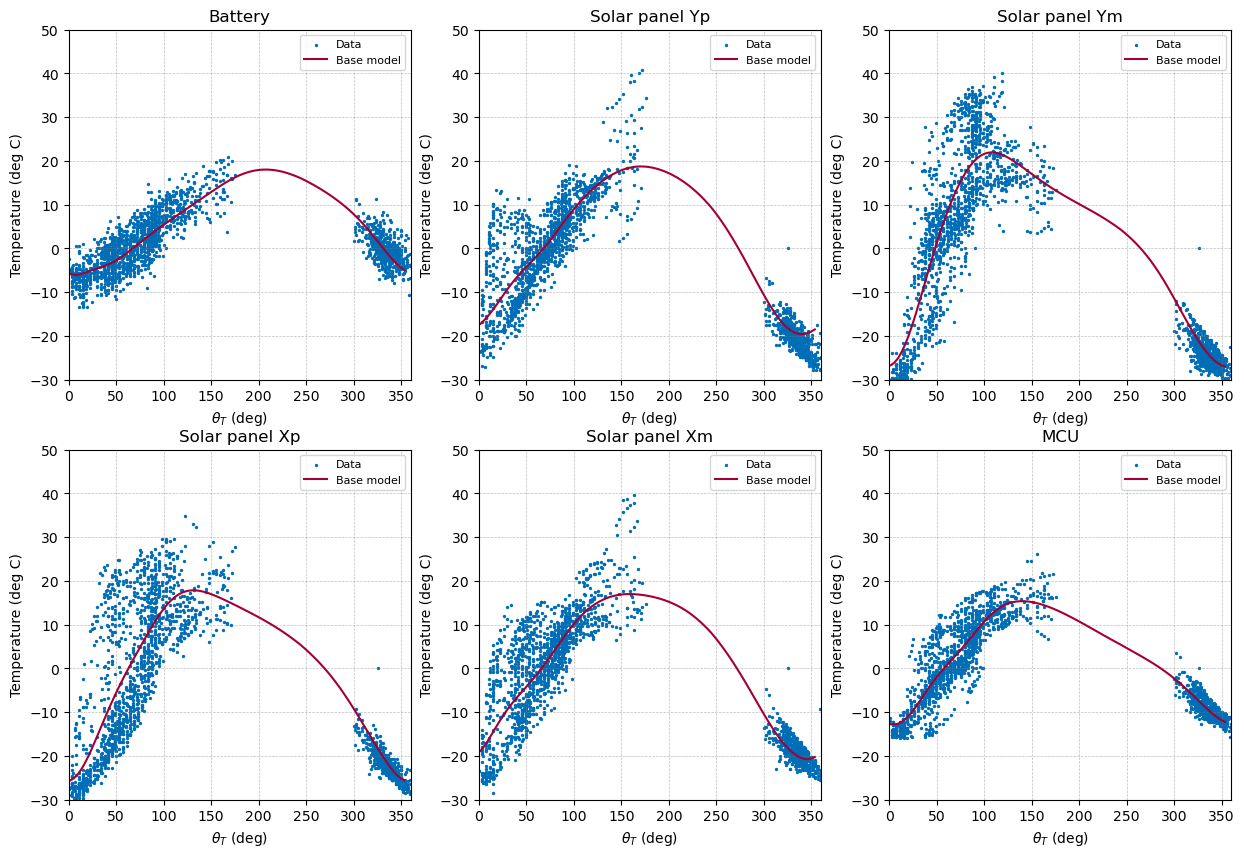

In [17]:
theta_T_vals = [base_train_df["theta_T"].to_numpy(), np.array(theta_T_list[97:])]
temp_vals = [denormalize_temperature(base_train_y, norm_limits), denormalize_temperature(artificial_test_y, norm_limits)]

# Plotting the temperature data
plot_model(
    theta_T_vals,
    temp_vals,
    plt_titles=["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"],
    labels=["Data", "Base model"],
    colors=[plt_colors[0], plt_colors[1]],
    plt_scatter=[True, False],
    limits=[-30, 50]
)

In [18]:
# Curve fit 
# Exponential fit on the temperature data with the following conditions:
#   - The temperature at theta_T = 0 and theta_T = 360 is the same
#   - The temperature at the end of the heating phase is the same as the temperature at the beginning of the cooling phase

fe_mean = np.mean(telem_df["fe"])   # Mean fe for the data
theta_E = 360 * (1 - fe_mean)       # Mean theta_E for the data

def fit_function(theta_T, T_sat_rising, r_rising, T_0, dT_0_falling):
    """
    Function to fit to the temperature data.
    :param theta_T: Array of theta_T values
    :param T_sat_rising: Saturation temperature of the heating phase
    :param r_rising: Rate of temperature rise during heating phase
    :param T_0: Temperature at theta_T = 0
    :param dT_0_falling: delta T between T_0 and saturation temperature of cooling phase
    """
    T_E = T_sat_rising * (1 - np.exp(-r_rising * theta_E)) + T_0    # Temperature at the beginning of ecllipse

    T_sat_falling = T_0 - dT_0_falling  # Saturation cooling temperature at theta_T = inf

    # Determining rate of falling temperature to satisfy T_begin = T_end at theta_E = 0 and theta_E = 360
    r_falling = -np.log(dT_0_falling / (T_E - T_sat_falling)) / (360 - theta_E)

    return_array = np.empty(shape=theta_T.shape, dtype=np.float64)

    for i, theta_T_i in enumerate(theta_T):
        if theta_T_i < theta_E:
            return_array[i] = T_sat_rising * (1 - np.exp(-r_rising * theta_T_i)) + T_0
        else:
            return_array[i] = (T_E - T_sat_falling) * np.exp(-r_falling * (theta_T_i - theta_E)) + T_sat_falling

    return return_array


# Fitting all temperature data:
fit_params = pd.DataFrame(
    columns=["T_sat_rising", "r_rising", "T_0", "dT_0_falling"],
)


for i in range(6):
    theta_T_data = base_train_df["theta_T"].to_numpy(dtype=np.float64)
    temp_data = denormalize_temperature(base_train_df.iloc[:, -6+i].to_numpy(dtype=np.float64), norm_limits) + 273.15

    popt, pcov = curve_fit(
        fit_function,
        theta_T_data,
        temp_data,
        p0=[25, 0.01, 300, 10],
        bounds=([0, 0, 200, 10], [100, 1, 350, 30]),
    )

    fit_params.loc[i] = popt

fit_params_np = fit_params.to_numpy(dtype=np.float64)

theta_T_fit = np.linspace(0, 360, 100)
temp_fit = np.empty(shape=(100, 6), dtype=np.float64)

for i in range(6):
    temp_fit[:, i] = fit_function(theta_T_fit, *fit_params.iloc[i]) - 273.15


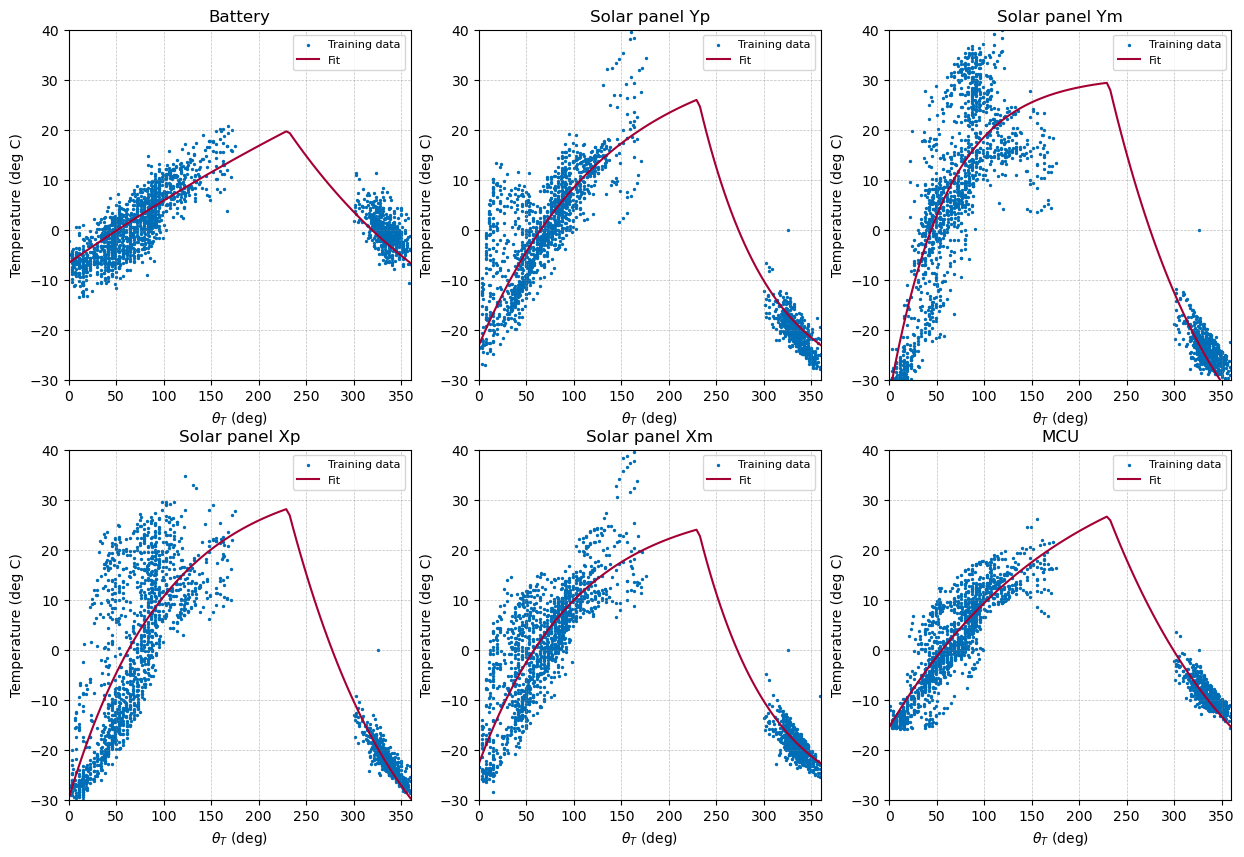

In [19]:


# Plotting the fit
theta_T_vals = [base_train_df["theta_T"].to_numpy(dtype=np.float64), theta_T_fit]
temp_vals = [
    denormalize_temperature(base_train_df.iloc[:, -6:].to_numpy(dtype=np.float64), norm_limits), 
    temp_fit
]

plot_model(
    theta_T_vals,
    temp_vals,
    plt_titles=["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"],
    labels=["Training data", "Fit"],
    colors=[plt_colors[0], plt_colors[1]],
    plt_scatter=[True, False],
    limits=[-30, 40],
)

In [20]:
# Using the curve fit as the base model
def curve_fit_model(theta_T):
    """
    Model that uses the curve fit as the base model.
    :param theta_T: Array of theta_T values

    :return: Array of temperature values
    """
    temp = np.empty(shape=(theta_T.shape[0], 6), dtype=np.float64)

    for i in range(6):
        temp[:, i] = fit_function(theta_T, *fit_params.iloc[i]) - 273.15

    return temp

Model: "base_simulated_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, None, 256)         264192    
                                                                 
 lstm_15 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_16 (LSTM)              (None, None, 128)         197120    
                                                                 
 lstm_17 (LSTM)              (None, None, 128)         131584    
                                                                 
 lstm_18 (LSTM)              (None, None, 64)          49408     
                                                                 
 lstm_19 (LSTM)              (None, None, 32)          12416     
                                                                 
 lstm_20 (LSTM)              (None, 16)       

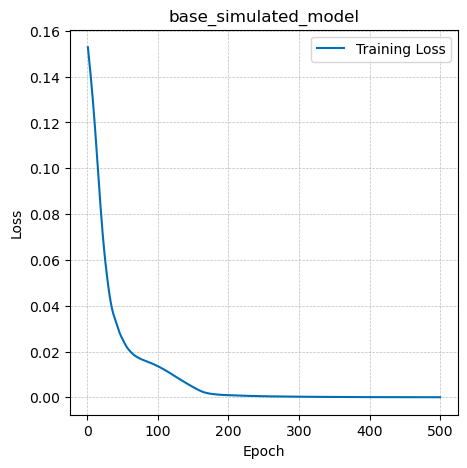

In [24]:
base_train_simulated_y = normalize_temperature(curve_fit_model(np.array(theta_T_list[97:])), norm_limits)

base_simulated_model = Model(
    artificial_test_x,
    base_train_simulated_y,
    None,
    None,
    name="base_simulated_model",
)   # initialize the base model

base_simulated_model.create_model(
    base_model_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=(None, 1),
    output_shape=6,
)   # create the base model

base_simulated_model.model.summary()

# Set initial weights to that of the base model
base_simulated_model.model.set_weights(base_model_weights)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=15,
    restore_best_weights=True,
)   # create an early stopping callback

base_simulated_model.train_model(500, early_stopping)   # train the base model

Simulated data


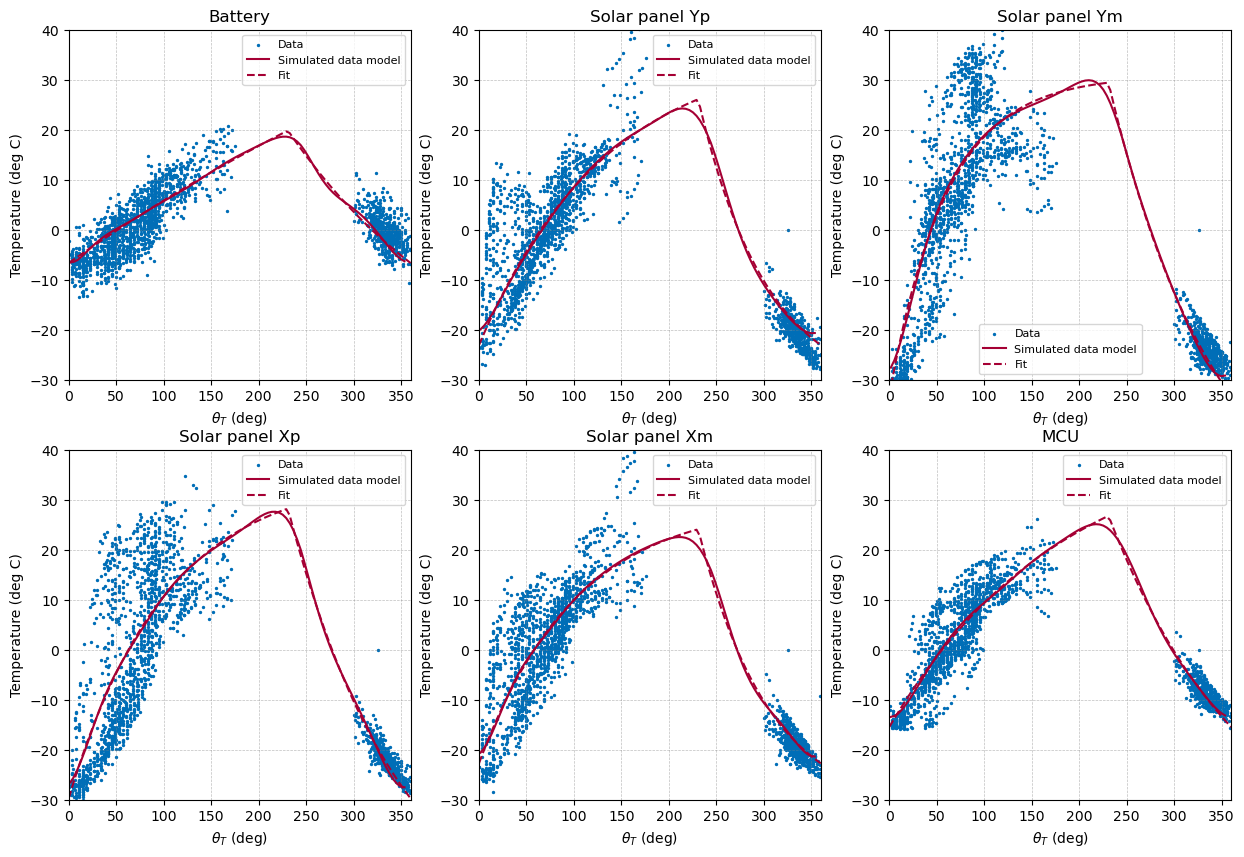

In [25]:
# Plotting the fit
theta_T_vals = [base_train_df["theta_T"].to_numpy(dtype=np.float64), np.array(theta_T_list[97:]), theta_T_fit]
temp_vals = [
    denormalize_temperature(base_train_df.iloc[:, -6:].to_numpy(dtype=np.float64), norm_limits), 
    denormalize_temperature(base_simulated_model.model.predict(artificial_test_x, verbose=0), norm_limits),
    temp_fit
]

print("Simulated data")
# Plotting the temperature data
plot_model(
    theta_T_vals,
    temp_vals,
    plt_titles=["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"],
    labels=["Data", "Simulated data model", "Fit"],
    colors=[plt_colors[0], plt_colors[1], plt_colors[1]],
    linestyles=[None, "-", "--"],
    plt_scatter=[True, False, False],
    limits=[-30, 40]
)

Epoch 1/100
20/20 [==============================] - 6s 295ms/step - loss: 0.0036 - mean_absolute_error: 0.0424 - val_loss: 0.0041 - val_mean_absolute_error: 0.0416
Epoch 2/100
20/20 [==============================] - 2s 110ms/step - loss: 0.0034 - mean_absolute_error: 0.0415 - val_loss: 0.0044 - val_mean_absolute_error: 0.0452
Epoch 3/100
20/20 [==============================] - 2s 97ms/step - loss: 0.0034 - mean_absolute_error: 0.0415 - val_loss: 0.0043 - val_mean_absolute_error: 0.0431
Epoch 4/100
20/20 [==============================] - 2s 92ms/step - loss: 0.0033 - mean_absolute_error: 0.0410 - val_loss: 0.0043 - val_mean_absolute_error: 0.0440
Epoch 5/100
20/20 [==============================] - 2s 89ms/step - loss: 0.0034 - mean_absolute_error: 0.0411 - val_loss: 0.0044 - val_mean_absolute_error: 0.0473
Epoch 6/100
20/20 [==============================] - 2s 91ms/step - loss: 0.0034 - mean_absolute_error: 0.0411 - val_loss: 0.0044 - val_mean_absolute_error: 0.0460
Epoch 7/100
20

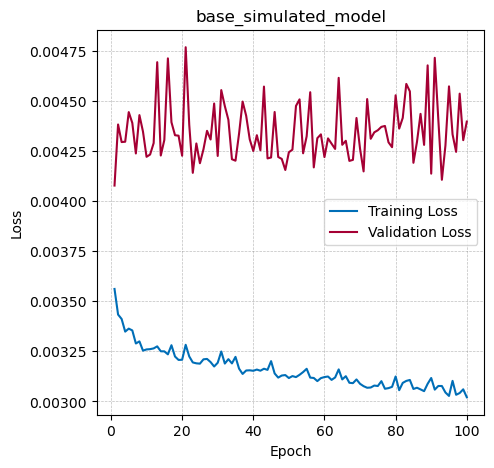

In [26]:
base_simulated_model.train_x = base_train_x
base_simulated_model.train_y = base_train_y
base_simulated_model.test_x = base_test_x
base_simulated_model.test_y = base_test_y

base_simulated_model.train_model(100, early_stopping)   # retrain the base model

Simulated -> actual


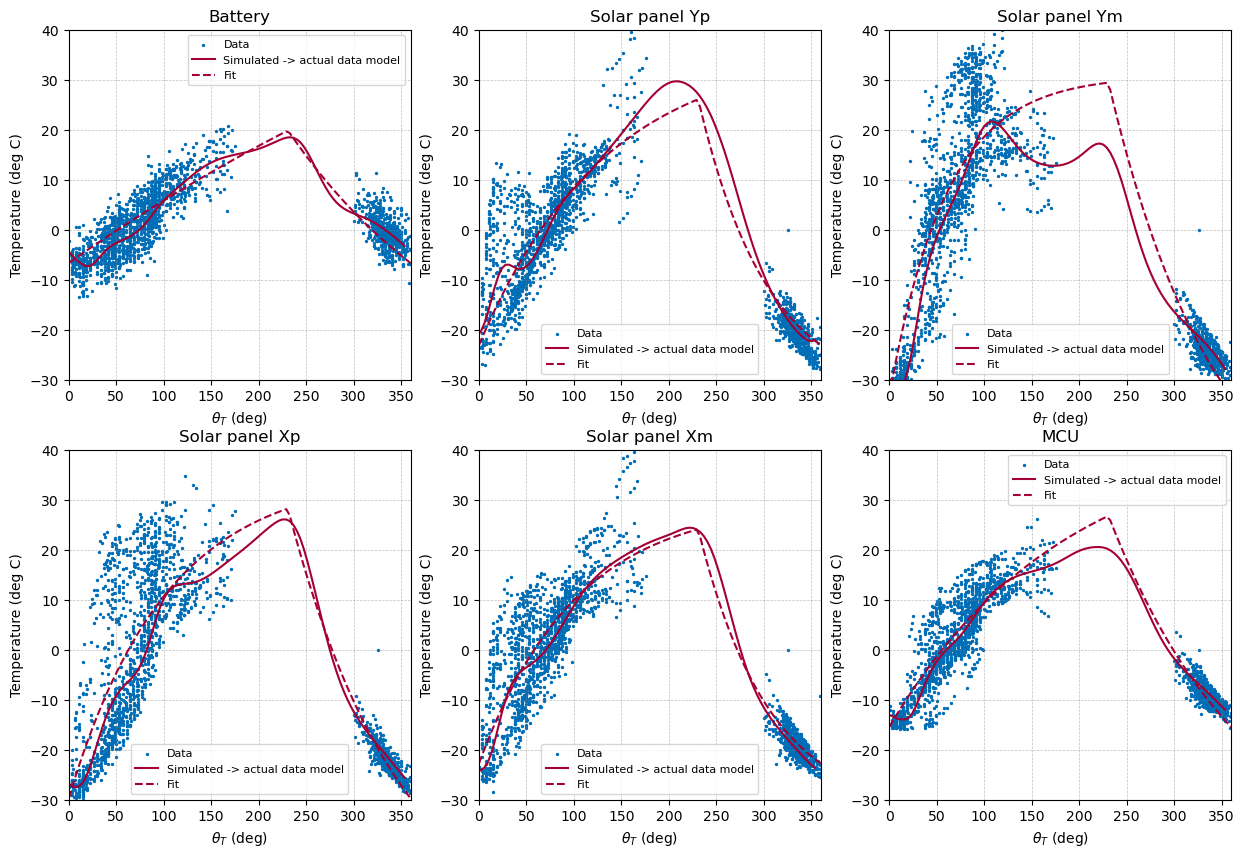

In [27]:
# Plotting the fit
theta_T_vals = [base_train_df["theta_T"].to_numpy(dtype=np.float64), np.array(theta_T_list[97:]), theta_T_fit]
temp_vals = [
    denormalize_temperature(base_train_df.iloc[:, -6:].to_numpy(dtype=np.float64), norm_limits), 
    denormalize_temperature(base_simulated_model.model.predict(artificial_test_x, verbose=0), norm_limits),
    temp_fit
]

print("Simulated -> actual")

# Plotting the temperature data
plot_model(
    theta_T_vals,
    temp_vals,
    plt_titles=["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"],
    labels=["Data", "Simulated -> actual data model", "Fit"],
    colors=[plt_colors[0], plt_colors[1], plt_colors[1]],
    linestyles=[None, "-", "--"],
    plt_scatter=[True, False, False],
    limits=[-30, 40]
)

Model: "base_simulated_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, None, 256)         264192    
                                                                 
 lstm_22 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_23 (LSTM)              (None, None, 128)         197120    
                                                                 
 lstm_24 (LSTM)              (None, None, 128)         131584    
                                                                 
 lstm_25 (LSTM)              (None, None, 64)          49408     
                                                                 
 lstm_26 (LSTM)              (None, None, 32)          12416     
                                                                 
 lstm_27 (LSTM)              (None, 16)     

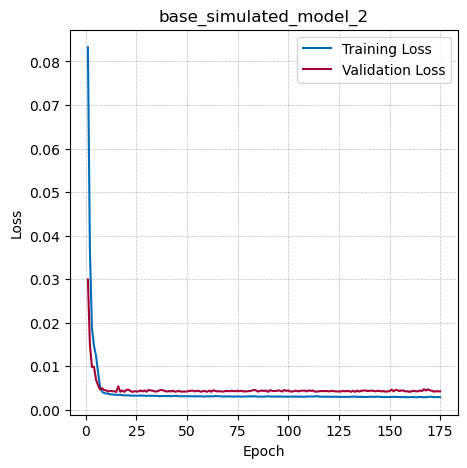

Epoch 1/250
1/1 [==============================] - 0s 87ms/step - loss: 0.0067 - mean_absolute_error: 0.0518
Epoch 2/250
1/1 [==============================] - 0s 79ms/step - loss: 0.0032 - mean_absolute_error: 0.0414
Epoch 3/250
1/1 [==============================] - 0s 66ms/step - loss: 0.0046 - mean_absolute_error: 0.0500
Epoch 4/250
1/1 [==============================] - 0s 76ms/step - loss: 0.0022 - mean_absolute_error: 0.0356
Epoch 5/250
1/1 [==============================] - 0s 66ms/step - loss: 0.0032 - mean_absolute_error: 0.0392
Epoch 6/250
1/1 [==============================] - 0s 66ms/step - loss: 0.0028 - mean_absolute_error: 0.0367
Epoch 7/250
1/1 [==============================] - 0s 79ms/step - loss: 0.0016 - mean_absolute_error: 0.0308
Epoch 8/250
1/1 [==============================] - 0s 66ms/step - loss: 0.0023 - mean_absolute_error: 0.0367
Epoch 9/250
1/1 [==============================] - 0s 75ms/step - loss: 0.0015 - mean_absolute_error: 0.0310
Epoch 10/250
1/1 [=

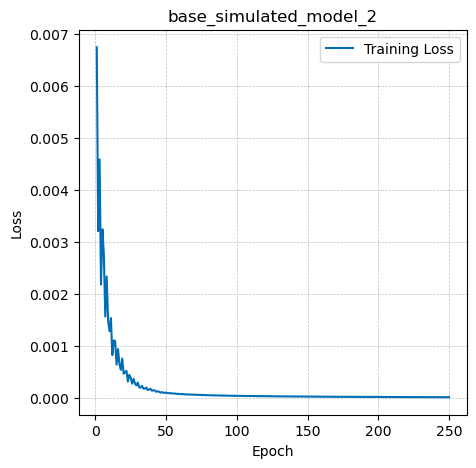

In [28]:
# Changing the order of training of the base model
base_simulated_model_2 = Model(
    base_train_x,
    base_train_y,
    base_test_x,
    base_test_y,
    name="base_simulated_model_2",
)

base_simulated_model_2.create_model(
    base_model_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=(None, 1),
    output_shape=6,
)

base_simulated_model_2.model.summary()

# Set initial weights to that of the base model
base_simulated_model_2.model.set_weights(base_model_weights)

base_simulated_model_2.train_model(250, early_stopping)

base_simulated_model_2.train_x = artificial_test_x
base_simulated_model_2.train_y = base_train_simulated_y
base_simulated_model_2.test_x = None
base_simulated_model_2.test_y = None

base_simulated_model_2.train_model(250, early_stopping)


Actual -> simulated


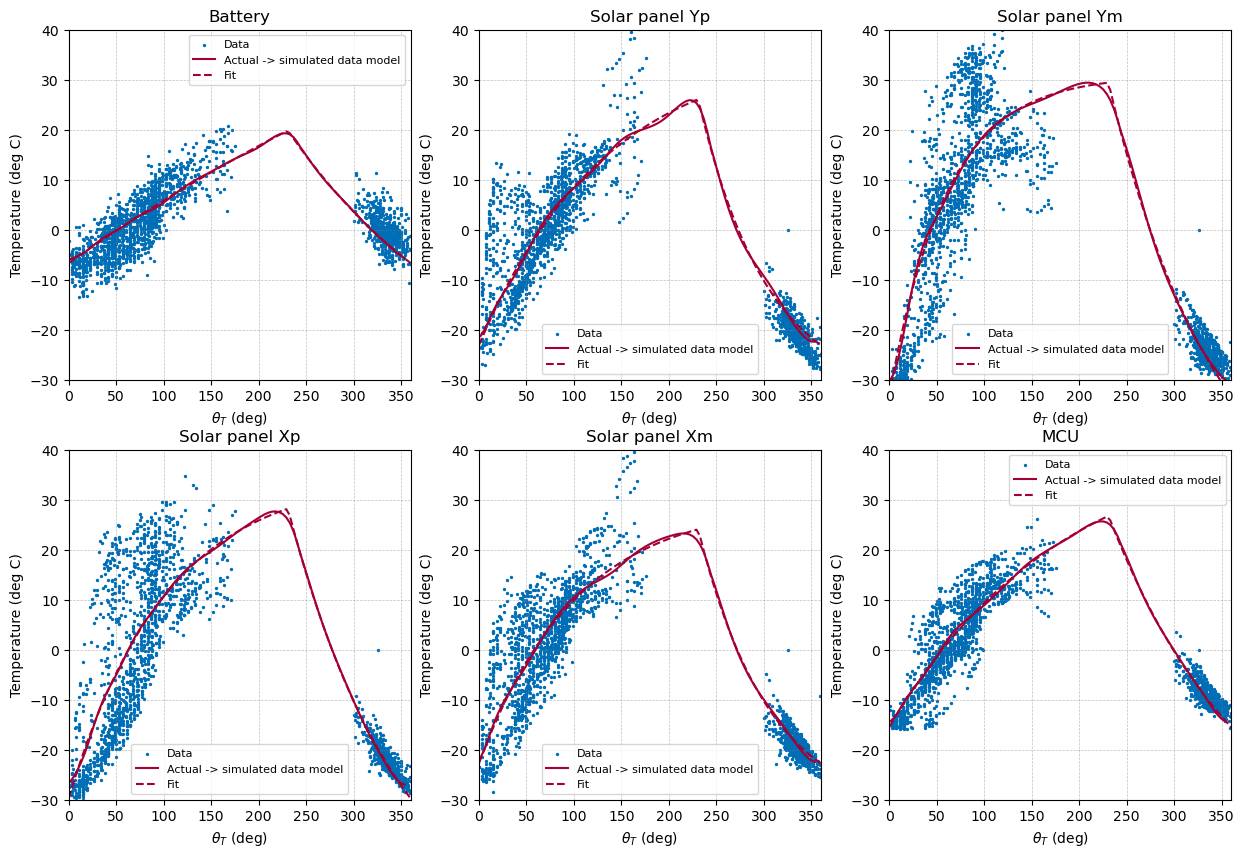

In [29]:
# Plotting the fit
theta_T_vals = [base_train_df["theta_T"].to_numpy(dtype=np.float64), np.array(theta_T_list[97:]), theta_T_fit]
temp_vals = [
    denormalize_temperature(base_train_df.iloc[:, -6:].to_numpy(dtype=np.float64), norm_limits), 
    denormalize_temperature(base_simulated_model_2.model.predict(artificial_test_x, verbose=0), norm_limits),
    temp_fit
]

print("Actual -> simulated")
# Plotting the temperature data
plot_model(
    theta_T_vals,
    temp_vals,
    plt_titles=["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"],
    labels=["Data", "Actual -> simulated data model", "Fit"],
    colors=[plt_colors[0], plt_colors[1], plt_colors[1]],
    linestyles=[None, "-", "--"],
    plt_scatter=[True, False, False],
    limits=[-30, 40]
)

Model: "base_simulated_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_63 (LSTM)              (None, None, 256)         264192    
                                                                 
 lstm_64 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_65 (LSTM)              (None, None, 128)         197120    
                                                                 
 lstm_66 (LSTM)              (None, None, 128)         131584    
                                                                 
 lstm_67 (LSTM)              (None, None, 64)          49408     
                                                                 
 lstm_68 (LSTM)              (None, None, 32)          12416     
                                                                 
 lstm_69 (LSTM)              (None, 16)     

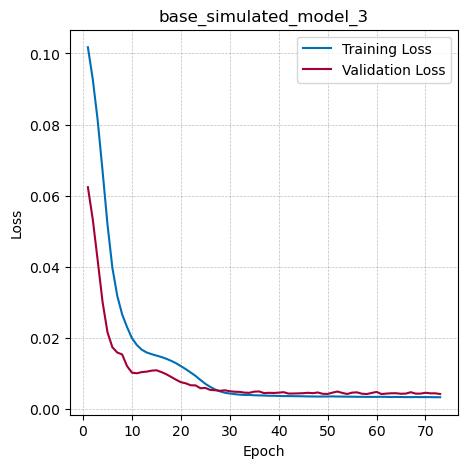

In [48]:
base_simulated_model_3 = Model(
    np.concatenate((base_train_x, artificial_test_x)),
    np.concatenate((base_train_y, base_train_simulated_y)),
    base_test_x,
    base_test_y,
    name="base_simulated_model_3",
)   # initialize the base model

base_simulated_model_3.create_model(
    base_model_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=(None, 1),
    output_shape=6,
)   # create the base model

base_simulated_model_3.model.summary()

# Getting the initial weights of the base model
base_simulated_model_3.model.set_weights(base_model_weights)   # set the initial weights of the base model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
)   # create an early stopping callback

base_simulated_model_3.train_model(500, early_stopping, 500)   # train the base model

Actual + simulated


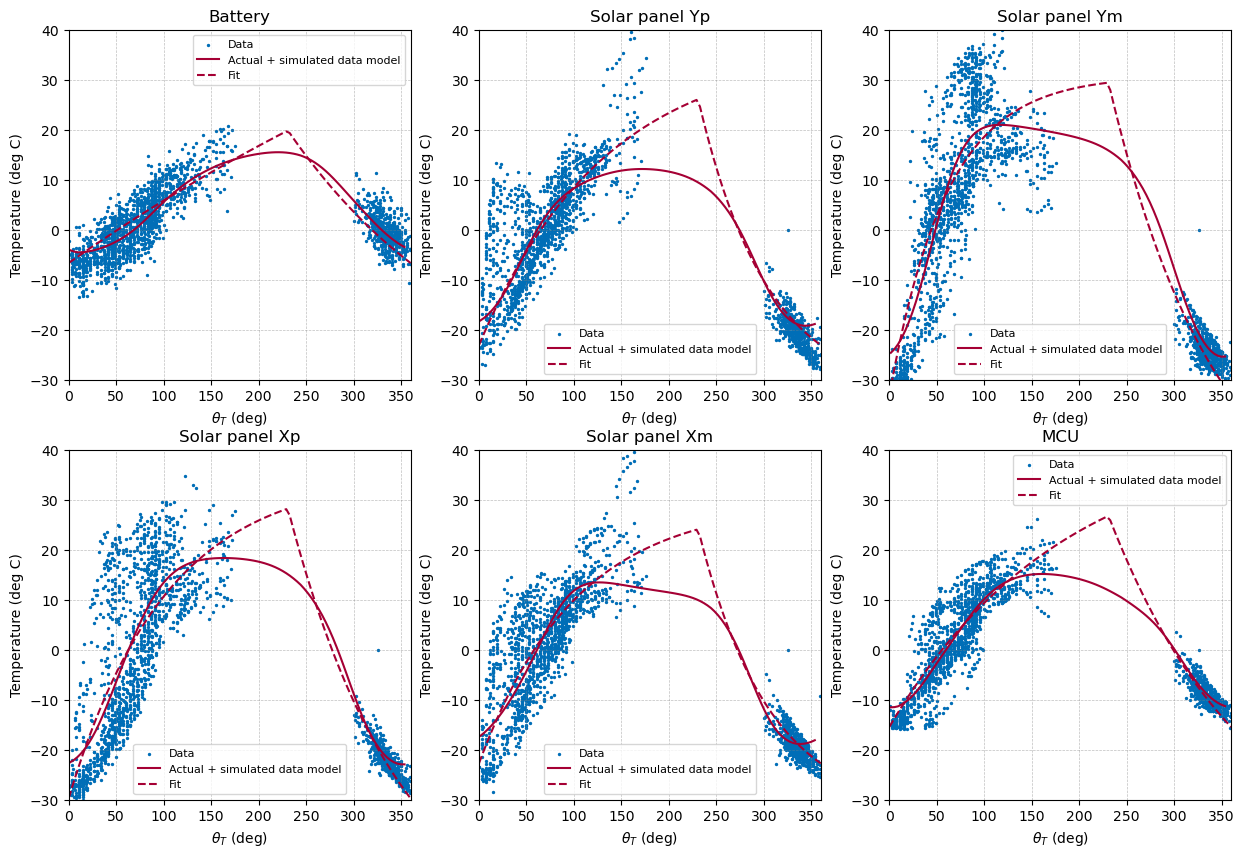

In [31]:
# Plotting the fit
theta_T_vals = [base_train_df["theta_T"].to_numpy(dtype=np.float64), np.array(theta_T_list[97:]), theta_T_fit]
temp_vals = [
    denormalize_temperature(base_train_df.iloc[:, -6:].to_numpy(dtype=np.float64), norm_limits), 
    denormalize_temperature(base_simulated_model_3.model.predict(artificial_test_x, verbose=0), norm_limits),
    temp_fit
]

print("Actual + simulated")
# Plotting the temperature data
plot_model(
    theta_T_vals,
    temp_vals,
    plt_titles=["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"],
    labels=["Data", "Actual + simulated data model", "Fit"],
    colors=[plt_colors[0], plt_colors[1], plt_colors[1]],
    linestyles=[None, "-", "--"],
    plt_scatter=[True, False, False],
    limits=[-30, 40]
)

3/3 [==============================] - 0s 24ms/step


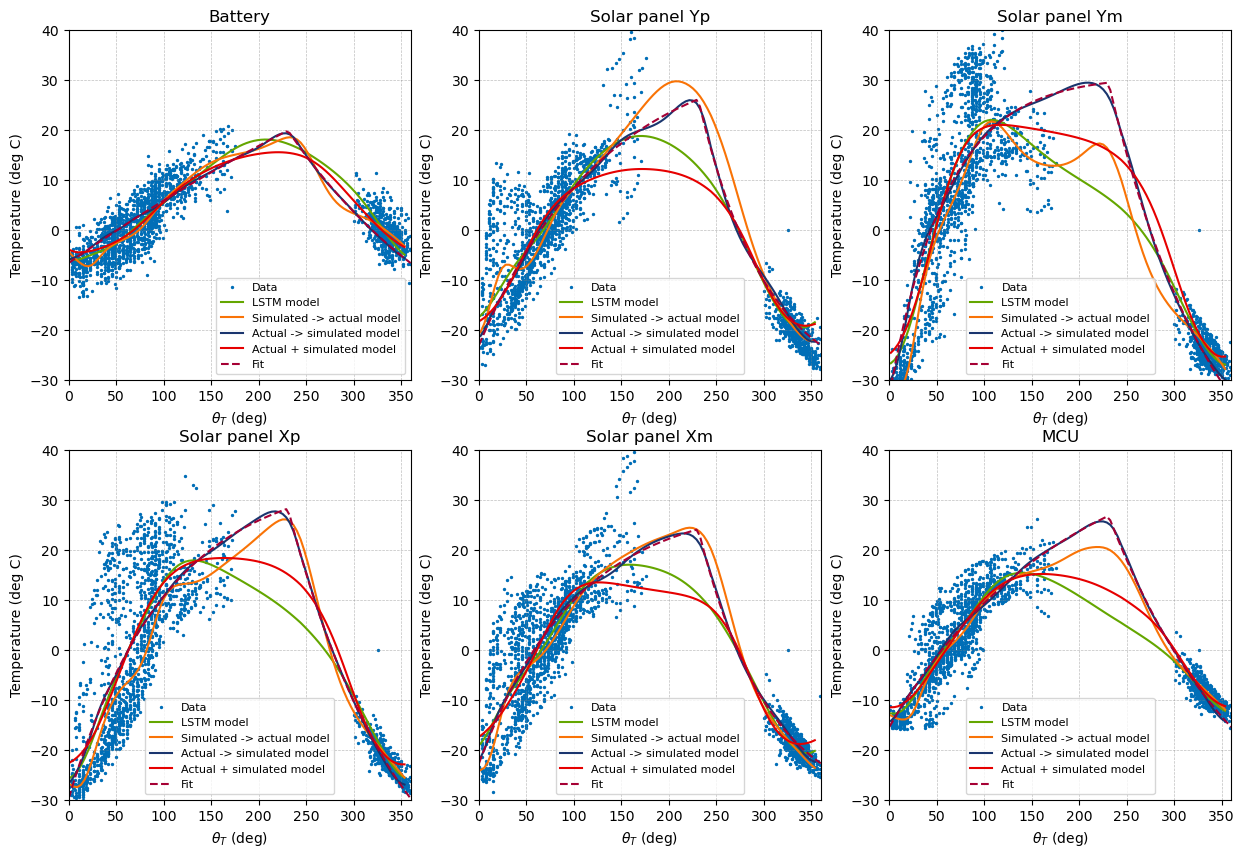

In [32]:
# Plotting the fit
theta_T_vals = [
    base_train_df["theta_T"].to_numpy(dtype=np.float64),    # data
    np.array(theta_T_list[97:]),    # LSTM model
    np.array(theta_T_list[97:]),    # simulated -> actual model
    np.array(theta_T_list[97:]),    # actual -> simulated model
    np.array(theta_T_list[97:]),    # actual + simulated model
    theta_T_fit,    # fit
]

temp_vals = [
    denormalize_temperature(base_train_df.iloc[:, -6:].to_numpy(dtype=np.float64), norm_limits),    # data
    denormalize_temperature(base_model.model.predict(artificial_test_x), norm_limits),    # LSTM model
    denormalize_temperature(base_simulated_model.model.predict(artificial_test_x), norm_limits),    # simulated -> actual model
    denormalize_temperature(base_simulated_model_2.model.predict(artificial_test_x), norm_limits),    # actual -> simulated model
    denormalize_temperature(base_simulated_model_3.model.predict(artificial_test_x), norm_limits),    # actual + simulated model
    temp_fit,    # fit
]

# Plotting the temperature data
plot_model(
    theta_T_vals,
    temp_vals,
    plt_titles=["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"],
    labels=["Data", "LSTM model", "Simulated -> actual model", "Actual -> simulated model", "Actual + simulated model", "Fit"],
    colors=[plt_colors[0], plt_colors[2], plt_colors[3], plt_colors[4], plt_colors[5], plt_colors[1]],
    linestyles=[None, "-", "-", "-", "-", "--"],
    plt_scatter=[True, False, False, False, False, False],
    limits=[-30, 40]
)

Epoch 1/750
5/5 [==============================] - 15s 1s/step - loss: 0.1018 - mean_absolute_error: 0.2926 - val_loss: 0.0624 - val_mean_absolute_error: 0.2302
Epoch 2/750
5/5 [==============================] - 1s 258ms/step - loss: 0.0927 - mean_absolute_error: 0.2769 - val_loss: 0.0533 - val_mean_absolute_error: 0.2088
Epoch 3/750
5/5 [==============================] - 1s 254ms/step - loss: 0.0812 - mean_absolute_error: 0.2540 - val_loss: 0.0418 - val_mean_absolute_error: 0.1756
Epoch 4/750
5/5 [==============================] - 1s 246ms/step - loss: 0.0669 - mean_absolute_error: 0.2197 - val_loss: 0.0300 - val_mean_absolute_error: 0.1293
Epoch 5/750
5/5 [==============================] - 1s 243ms/step - loss: 0.0519 - mean_absolute_error: 0.1803 - val_loss: 0.0215 - val_mean_absolute_error: 0.1061
Epoch 6/750
5/5 [==============================] - 1s 244ms/step - loss: 0.0397 - mean_absolute_error: 0.1561 - val_loss: 0.0173 - val_mean_absolute_error: 0.1024
Epoch 7/750
5/5 [=======

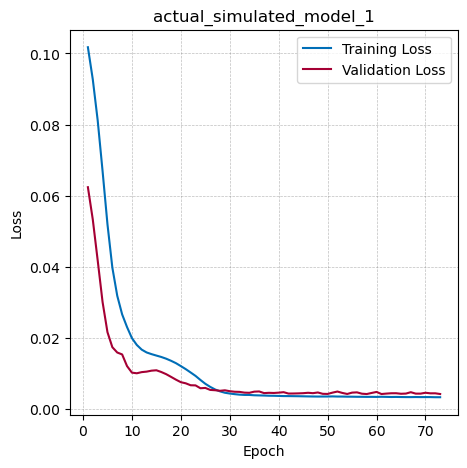

Epoch 1/750
5/5 [==============================] - 17s 939ms/step - loss: 0.1036 - mean_absolute_error: 0.2954 - val_loss: 0.0624 - val_mean_absolute_error: 0.2302
Epoch 2/750
5/5 [==============================] - 1s 256ms/step - loss: 0.0942 - mean_absolute_error: 0.2792 - val_loss: 0.0533 - val_mean_absolute_error: 0.2088
Epoch 3/750
5/5 [==============================] - 1s 255ms/step - loss: 0.0822 - mean_absolute_error: 0.2558 - val_loss: 0.0419 - val_mean_absolute_error: 0.1757
Epoch 4/750
5/5 [==============================] - 1s 258ms/step - loss: 0.0676 - mean_absolute_error: 0.2209 - val_loss: 0.0302 - val_mean_absolute_error: 0.1297
Epoch 5/750
5/5 [==============================] - 1s 260ms/step - loss: 0.0526 - mean_absolute_error: 0.1818 - val_loss: 0.0216 - val_mean_absolute_error: 0.1060
Epoch 6/750
5/5 [==============================] - 1s 255ms/step - loss: 0.0403 - mean_absolute_error: 0.1579 - val_loss: 0.0174 - val_mean_absolute_error: 0.1027
Epoch 7/750
5/5 [====

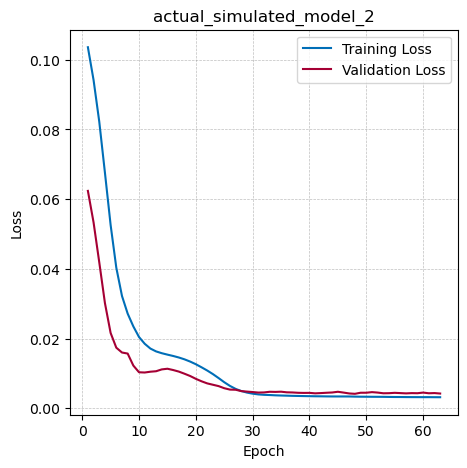

Epoch 1/750
5/5 [==============================] - 13s 934ms/step - loss: 0.1053 - mean_absolute_error: 0.2978 - val_loss: 0.0624 - val_mean_absolute_error: 0.2302
Epoch 2/750
5/5 [==============================] - 1s 254ms/step - loss: 0.0955 - mean_absolute_error: 0.2812 - val_loss: 0.0533 - val_mean_absolute_error: 0.2088
Epoch 3/750
5/5 [==============================] - 1s 262ms/step - loss: 0.0832 - mean_absolute_error: 0.2572 - val_loss: 0.0419 - val_mean_absolute_error: 0.1758
Epoch 4/750
5/5 [==============================] - 1s 262ms/step - loss: 0.0682 - mean_absolute_error: 0.2219 - val_loss: 0.0302 - val_mean_absolute_error: 0.1298
Epoch 5/750
5/5 [==============================] - 1s 249ms/step - loss: 0.0529 - mean_absolute_error: 0.1825 - val_loss: 0.0216 - val_mean_absolute_error: 0.1060
Epoch 6/750
5/5 [==============================] - 1s 252ms/step - loss: 0.0406 - mean_absolute_error: 0.1585 - val_loss: 0.0174 - val_mean_absolute_error: 0.1031
Epoch 7/750
5/5 [====

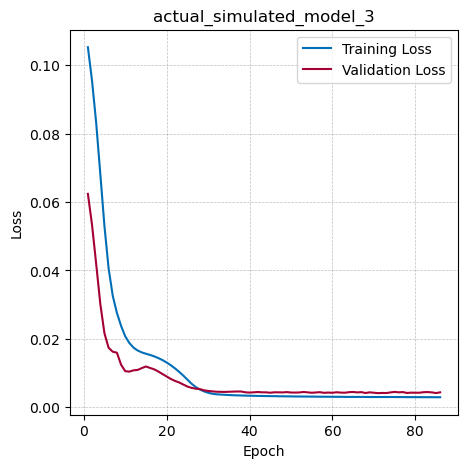

Epoch 1/750
5/5 [==============================] - 14s 876ms/step - loss: 0.1069 - mean_absolute_error: 0.3002 - val_loss: 0.0624 - val_mean_absolute_error: 0.2302
Epoch 2/750
5/5 [==============================] - 1s 263ms/step - loss: 0.0967 - mean_absolute_error: 0.2831 - val_loss: 0.0534 - val_mean_absolute_error: 0.2089
Epoch 3/750
5/5 [==============================] - 1s 265ms/step - loss: 0.0841 - mean_absolute_error: 0.2587 - val_loss: 0.0420 - val_mean_absolute_error: 0.1759
Epoch 4/750
5/5 [==============================] - 1s 264ms/step - loss: 0.0687 - mean_absolute_error: 0.2228 - val_loss: 0.0303 - val_mean_absolute_error: 0.1301
Epoch 5/750
5/5 [==============================] - 1s 263ms/step - loss: 0.0533 - mean_absolute_error: 0.1836 - val_loss: 0.0216 - val_mean_absolute_error: 0.1060
Epoch 6/750
5/5 [==============================] - 1s 263ms/step - loss: 0.0410 - mean_absolute_error: 0.1597 - val_loss: 0.0174 - val_mean_absolute_error: 0.1033
Epoch 7/750
5/5 [====

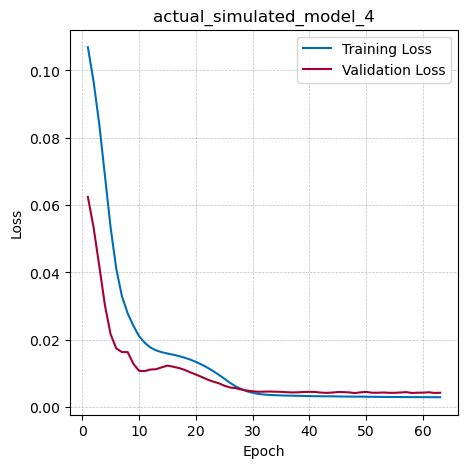

Epoch 1/750
5/5 [==============================] - 14s 897ms/step - loss: 0.1082 - mean_absolute_error: 0.3022 - val_loss: 0.0624 - val_mean_absolute_error: 0.2302
Epoch 2/750
5/5 [==============================] - 1s 287ms/step - loss: 0.0979 - mean_absolute_error: 0.2849 - val_loss: 0.0534 - val_mean_absolute_error: 0.2089
Epoch 3/750
5/5 [==============================] - 1s 278ms/step - loss: 0.0849 - mean_absolute_error: 0.2601 - val_loss: 0.0420 - val_mean_absolute_error: 0.1759
Epoch 4/750
5/5 [==============================] - 1s 285ms/step - loss: 0.0692 - mean_absolute_error: 0.2237 - val_loss: 0.0303 - val_mean_absolute_error: 0.1303
Epoch 5/750
5/5 [==============================] - 1s 280ms/step - loss: 0.0537 - mean_absolute_error: 0.1846 - val_loss: 0.0217 - val_mean_absolute_error: 0.1060
Epoch 6/750
5/5 [==============================] - 1s 279ms/step - loss: 0.0414 - mean_absolute_error: 0.1607 - val_loss: 0.0174 - val_mean_absolute_error: 0.1034
Epoch 7/750
5/5 [====

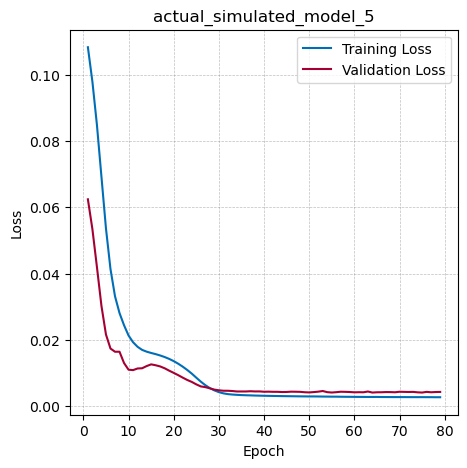

Epoch 1/750
6/6 [==============================] - 13s 739ms/step - loss: 0.1095 - mean_absolute_error: 0.3041 - val_loss: 0.0608 - val_mean_absolute_error: 0.2266
Epoch 2/750
6/6 [==============================] - 1s 240ms/step - loss: 0.0964 - mean_absolute_error: 0.2822 - val_loss: 0.0491 - val_mean_absolute_error: 0.1975
Epoch 3/750
6/6 [==============================] - 1s 239ms/step - loss: 0.0794 - mean_absolute_error: 0.2481 - val_loss: 0.0349 - val_mean_absolute_error: 0.1495
Epoch 4/750
6/6 [==============================] - 1s 241ms/step - loss: 0.0601 - mean_absolute_error: 0.1997 - val_loss: 0.0231 - val_mean_absolute_error: 0.1084
Epoch 5/750
6/6 [==============================] - 1s 240ms/step - loss: 0.0438 - mean_absolute_error: 0.1651 - val_loss: 0.0175 - val_mean_absolute_error: 0.1035
Epoch 6/750
6/6 [==============================] - 1s 239ms/step - loss: 0.0334 - mean_absolute_error: 0.1476 - val_loss: 0.0169 - val_mean_absolute_error: 0.1085
Epoch 7/750
6/6 [====

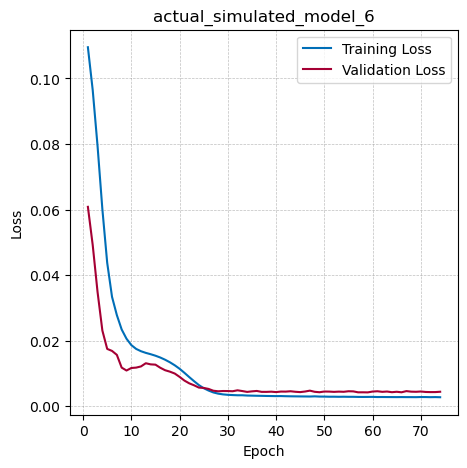

Epoch 1/750
6/6 [==============================] - 13s 744ms/step - loss: 0.1106 - mean_absolute_error: 0.3057 - val_loss: 0.0608 - val_mean_absolute_error: 0.2266
Epoch 2/750
6/6 [==============================] - 1s 249ms/step - loss: 0.0972 - mean_absolute_error: 0.2834 - val_loss: 0.0492 - val_mean_absolute_error: 0.1975
Epoch 3/750
6/6 [==============================] - 1s 244ms/step - loss: 0.0798 - mean_absolute_error: 0.2486 - val_loss: 0.0349 - val_mean_absolute_error: 0.1497
Epoch 4/750
6/6 [==============================] - 1s 244ms/step - loss: 0.0603 - mean_absolute_error: 0.2001 - val_loss: 0.0232 - val_mean_absolute_error: 0.1087
Epoch 5/750
6/6 [==============================] - 1s 245ms/step - loss: 0.0441 - mean_absolute_error: 0.1659 - val_loss: 0.0175 - val_mean_absolute_error: 0.1035
Epoch 6/750
6/6 [==============================] - 1s 242ms/step - loss: 0.0336 - mean_absolute_error: 0.1482 - val_loss: 0.0168 - val_mean_absolute_error: 0.1084
Epoch 7/750
6/6 [====

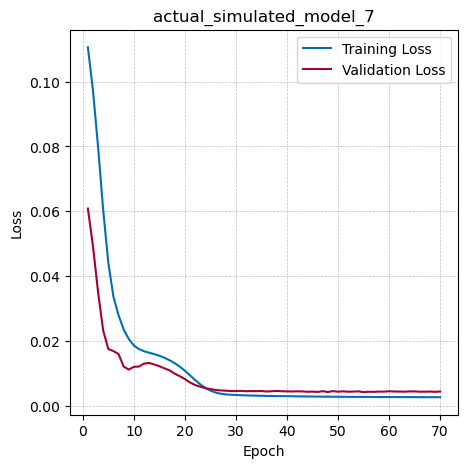

Epoch 1/750
6/6 [==============================] - 15s 713ms/step - loss: 0.1117 - mean_absolute_error: 0.3073 - val_loss: 0.0608 - val_mean_absolute_error: 0.2266
Epoch 2/750
6/6 [==============================] - 1s 251ms/step - loss: 0.0978 - mean_absolute_error: 0.2844 - val_loss: 0.0491 - val_mean_absolute_error: 0.1974
Epoch 3/750
6/6 [==============================] - 2s 255ms/step - loss: 0.0801 - mean_absolute_error: 0.2491 - val_loss: 0.0349 - val_mean_absolute_error: 0.1495
Epoch 4/750
6/6 [==============================] - 1s 251ms/step - loss: 0.0605 - mean_absolute_error: 0.2004 - val_loss: 0.0231 - val_mean_absolute_error: 0.1086
Epoch 5/750
6/6 [==============================] - 2s 254ms/step - loss: 0.0442 - mean_absolute_error: 0.1664 - val_loss: 0.0175 - val_mean_absolute_error: 0.1037
Epoch 6/750
6/6 [==============================] - 2s 253ms/step - loss: 0.0339 - mean_absolute_error: 0.1488 - val_loss: 0.0169 - val_mean_absolute_error: 0.1086
Epoch 7/750
6/6 [====

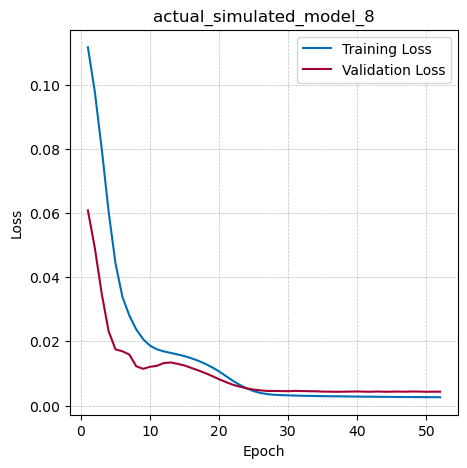

Epoch 1/750
6/6 [==============================] - 14s 757ms/step - loss: 0.1126 - mean_absolute_error: 0.3087 - val_loss: 0.0608 - val_mean_absolute_error: 0.2266
Epoch 2/750
6/6 [==============================] - 2s 259ms/step - loss: 0.0986 - mean_absolute_error: 0.2856 - val_loss: 0.0492 - val_mean_absolute_error: 0.1975
Epoch 3/750
6/6 [==============================] - 2s 263ms/step - loss: 0.0805 - mean_absolute_error: 0.2496 - val_loss: 0.0350 - val_mean_absolute_error: 0.1498
Epoch 4/750
6/6 [==============================] - 2s 262ms/step - loss: 0.0608 - mean_absolute_error: 0.2009 - val_loss: 0.0232 - val_mean_absolute_error: 0.1087
Epoch 5/750
6/6 [==============================] - 2s 261ms/step - loss: 0.0445 - mean_absolute_error: 0.1671 - val_loss: 0.0175 - val_mean_absolute_error: 0.1038
Epoch 6/750
6/6 [==============================] - 2s 258ms/step - loss: 0.0340 - mean_absolute_error: 0.1490 - val_loss: 0.0170 - val_mean_absolute_error: 0.1090
Epoch 7/750
6/6 [====

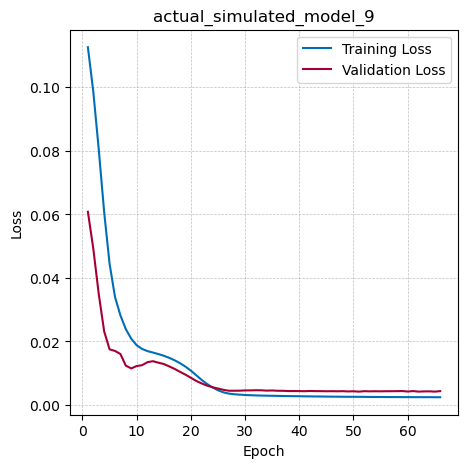

Epoch 1/750
6/6 [==============================] - 14s 758ms/step - loss: 0.1135 - mean_absolute_error: 0.3100 - val_loss: 0.0608 - val_mean_absolute_error: 0.2266
Epoch 2/750
6/6 [==============================] - 2s 271ms/step - loss: 0.0991 - mean_absolute_error: 0.2864 - val_loss: 0.0492 - val_mean_absolute_error: 0.1975
Epoch 3/750
6/6 [==============================] - 2s 268ms/step - loss: 0.0808 - mean_absolute_error: 0.2500 - val_loss: 0.0350 - val_mean_absolute_error: 0.1497
Epoch 4/750
6/6 [==============================] - 2s 270ms/step - loss: 0.0608 - mean_absolute_error: 0.2013 - val_loss: 0.0232 - val_mean_absolute_error: 0.1087
Epoch 5/750
6/6 [==============================] - 2s 273ms/step - loss: 0.0446 - mean_absolute_error: 0.1674 - val_loss: 0.0175 - val_mean_absolute_error: 0.1039
Epoch 6/750
6/6 [==============================] - 2s 271ms/step - loss: 0.0342 - mean_absolute_error: 0.1494 - val_loss: 0.0171 - val_mean_absolute_error: 0.1093
Epoch 7/750
6/6 [====

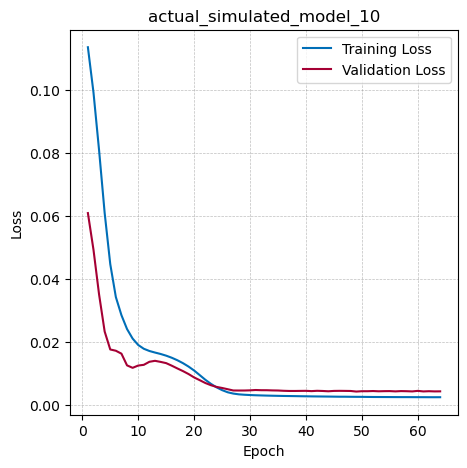

In [53]:
# Testing the effect of the amount of simulated data on the accuracy of the model
simulated_orbits = np.arange(1, 21)

base_simulated_models = []
for i in simulated_orbits:
    train_x = base_train_x
    train_y = base_train_y
    for j in range(i):
        train_x = np.concatenate((train_x, artificial_test_x))
        train_y = np.concatenate((train_y, base_train_simulated_y))

    simulated_model = Model(
        train_x,
        train_y,
        base_test_x,
        base_test_y,
        name=f"actual_simulated_model_{i}"
    )

    simulated_model.create_model(
        base_model_layers,
        tf.keras.optimizers.Adam(learning_rate=5e-5),
        tf.keras.losses.MeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError(),
        input_shape=(None, 1),
        output_shape=6,
    )   # create the base model

    simulated_model.model.set_weights(base_model_weights)

    simulated_model.train_model(750, early_stopping, batch_size=500)

    base_simulated_models.append(simulated_model)

In [67]:
# Error statistics of the models:
data_error_mean = np.empty(len(base_simulated_models), dtype=np.float32)    # mean error w.r.t the data
data_error_std = np.empty(len(base_simulated_models), dtype=np.float32)    # standard deviation of the error w.r.t the data
fit_error_mean = np.empty(len(base_simulated_models), dtype=np.float32)    # mean error w.r.t the fit
fit_error_mean = np.empty(len(base_simulated_models), dtype=np.float32)    # standard deviation of the error w.r.t the fit

for i, model in enumerate(base_simulated_models):
    data_error = (base_test_y - model.model.predict(base_test_x, verbose=0)) * (norm_limits[1] - norm_limits[0])
    data_error_mean[i] = np.mean(data_error)
    data_error_std[i] = np.std(data_error)

    fit_error = (base_train_simulated_y - model.model.predict(artificial_test_x, verbose=0)) * (norm_limits[1] - norm_limits[0])
    fit_error_mean[i] = np.mean(fit_error)
    fit_error_mean[i] = np.std(fit_error)

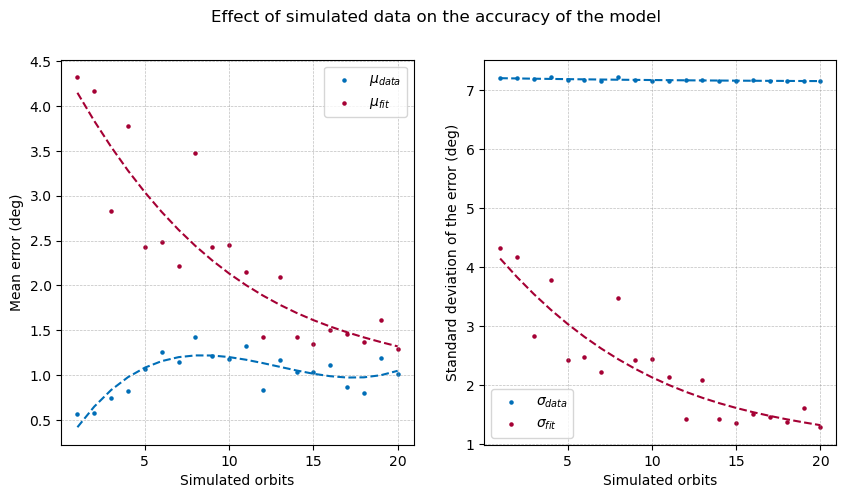

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(
    simulated_orbits,
    data_error_mean,
    color=plt_colors[0],
    label=r"$\mu_{data}$",
    s=5
)
ax[0].scatter(
    simulated_orbits,
    fit_error_mean,
    color=plt_colors[1],
    label=r"$\mu_{fit}$",
    s=5
)
# Trend lines:
z = np.polyfit(simulated_orbits, data_error_mean, 3)
p = np.poly1d(z)
ax[0].plot(
    simulated_orbits,
    p(simulated_orbits),
    color=plt_colors[0],
    linestyle="--",
)
z = np.polyfit(simulated_orbits, fit_error_mean, 3)
p = np.poly1d(z)
ax[0].plot(
    simulated_orbits,
    p(simulated_orbits),
    color=plt_colors[1],
    linestyle="--",
)
ax[0].set_xlabel("Simulated orbits")
ax[0].set_ylabel("Mean error (deg)")
ax[0].legend()
ax[0].grid()

ax[1].scatter(
    simulated_orbits,
    data_error_std,
    color=plt_colors[0],
    label=r"$\sigma_{data}$",
    s=5
)
ax[1].scatter(
    simulated_orbits,
    fit_error_mean,
    color=plt_colors[1],
    label=r"$\sigma_{fit}$",
    s=5
)
# Trend lines:
z = np.polyfit(simulated_orbits, data_error_std, 3)
p = np.poly1d(z)
ax[1].plot(
    simulated_orbits,
    p(simulated_orbits),
    color=plt_colors[0],
    linestyle="--",
)
z = np.polyfit(simulated_orbits, fit_error_mean, 3)
p = np.poly1d(z)
ax[1].plot(
    simulated_orbits,
    p(simulated_orbits),
    color=plt_colors[1],
    linestyle="--",
)

ax[1].set_xlabel("Simulated orbits")
ax[1].set_ylabel("Standard deviation of the error (deg)")
ax[1].legend()
ax[1].grid()

plt.suptitle("Effect of simulated data on the accuracy of the model")
plt.show()

In [81]:
a = np.array([1, 2, 3, 4])
print(2 in a-1 )

True


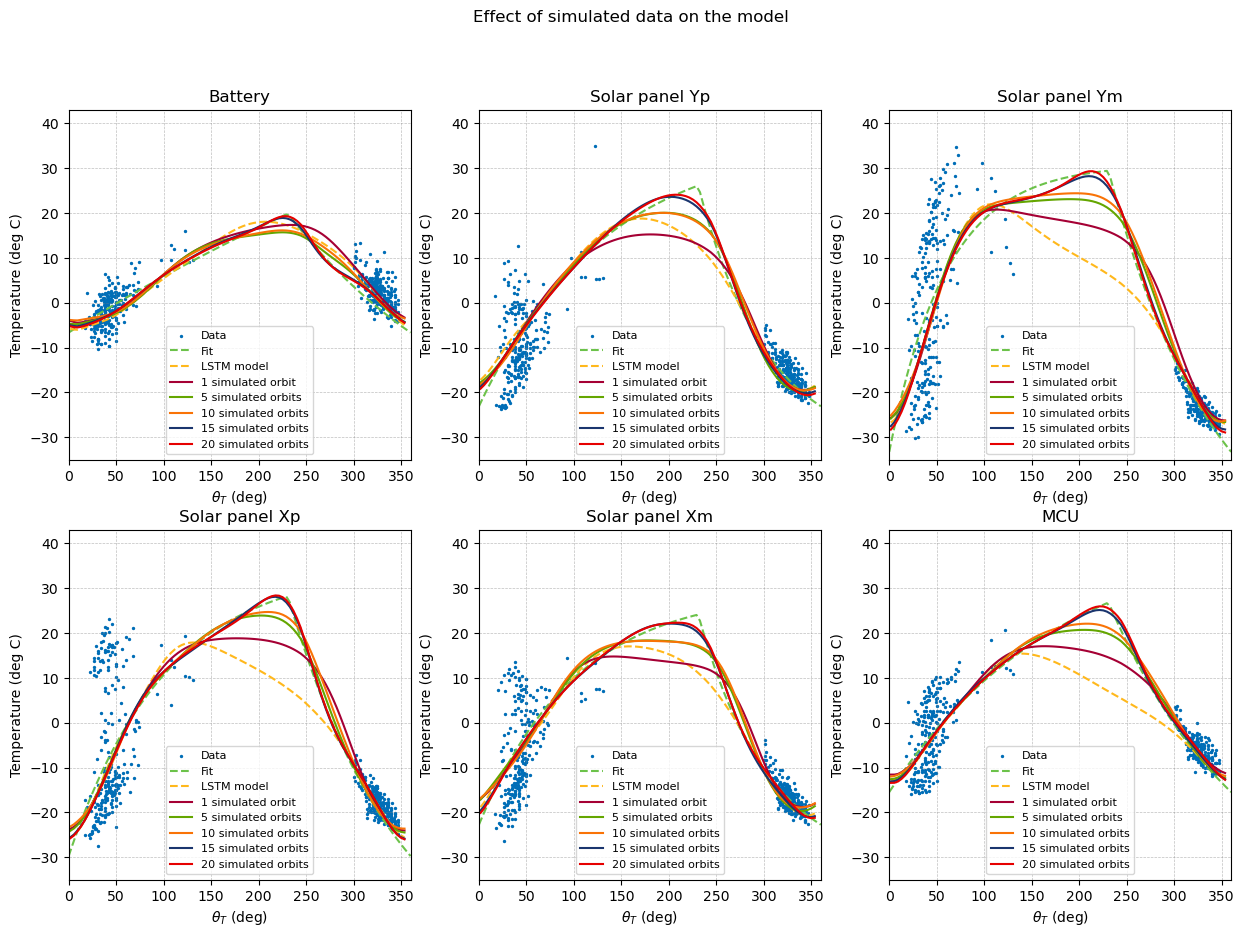

In [82]:
theta_T_vals = [base_test_df["theta_T"].to_numpy()]
temp_vals = [denormalize_temperature(base_test_df.iloc[:, -6:].to_numpy(), norm_limits)]

theta_T_vals.append(theta_T_fit)
for i in range(6):
    theta_T_vals.append(theta_T_list[97:])

temp_vals.append(temp_fit)
temp_vals.append(denormalize_temperature(base_model.model.predict(artificial_test_x, verbose=0), norm_limits))

plot_orbits = np.array([1, 5, 10, 15, 20])
for i, model in enumerate(base_simulated_models):
    if i in plot_orbits - 1:
        temp_vals.append(denormalize_temperature(model.model.predict(artificial_test_x, verbose=0), norm_limits))

plot_model(
    theta_T_vals,
    temp_vals,
    plt_titles=[
        "Battery",
        "Solar panel Yp",
        "Solar panel Ym",
        "Solar panel Xp",
        "Solar panel Xm",
        "MCU",
    ],
    labels=[
        "Data",
        "Fit",
        "LSTM model",
        "1 simulated orbit",
        "5 simulated orbits",
        "10 simulated orbits",
        "15 simulated orbits",
        "20 simulated orbits",
    ],
    colors=[
        plt_colors[0],
        plt_colors[6],
        plt_colors[7],
        plt_colors[1],
        plt_colors[2],
        plt_colors[3],
        plt_colors[4],
        plt_colors[5],
    ],
    plt_scatter=[True, False, False, False, False, False, False, False],
    linestyles=[None, "--", "--", "-", "-", "-", "-", "-",],
    limits=[-35, 43],
    plt_suptitle="Effect of simulated data on the model",
)

In [ ]:
# Getting all the weights of the base_simulated_model_3
model_weights = base_simulated_model_3.model.get_weights()
weights_list = np.array([], dtype=np.float32)
bias_list = np.array([], dtype=np.float32)
for i in range(7):
    weights_list = np.append(weights_list, model_weights[3*i].flatten())   # input weights
    weights_list = np.append(weights_list, model_weights[3*i+1].flatten())   # recurrent weights
    bias_list = np.append(bias_list, model_weights[3*i+2].flatten())   # bias

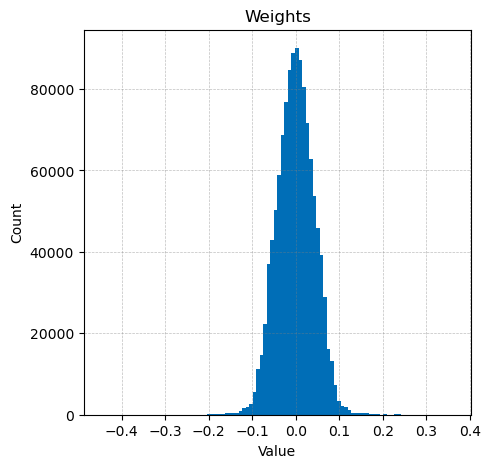

In [ ]:
# Plotting a histogram of the weights
plt.figure(figsize=(5, 5))
plt.hist(weights_list, bins=100, color=plt_colors[0])
plt.title("Weights")
plt.xlabel("Value")
plt.ylabel("Count")
plt.grid()
plt.show()

In [ ]:
# Calculating the average output of each neuron for the base_simulated_model_3
layer_outputs = [layer.output for layer in base_simulated_model_3.model.layers]
activation_model = tf.keras.models.Model(inputs=base_simulated_model_3.model.input, outputs=layer_outputs)
activations = activation_model.predict(base_test_x)

average_outputs = []
std_outputs = []

for i in range(len(activations) - 2):
    average_output = np.empty(shape=(activations[i].shape[-1]), dtype=np.float32)
    std_output = np.empty(shape=(activations[i].shape[-1]), dtype=np.float32)
    for j in range(activations[i].shape[-1]):
        average_output[j] = np.mean(activations[i][:, -1, j])
        std_output[j] = np.std(activations[i][:, -1, j])

    average_outputs.append(average_output)
    std_outputs.append(std_output)

average_output = np.empty(shape=(activations[-2].shape[-1]), dtype=np.float32)
std_output = np.empty(shape=(activations[-2].shape[-1]), dtype=np.float32)
for j in range(activations[-2].shape[-1]):
    average_output[j] = np.mean(activations[-2][:, j])
    std_output[j] = np.std(activations[-2][:, j])

average_outputs.append(average_output)
std_outputs.append(std_output)


16/16 [==============================] - 3s 23ms/step


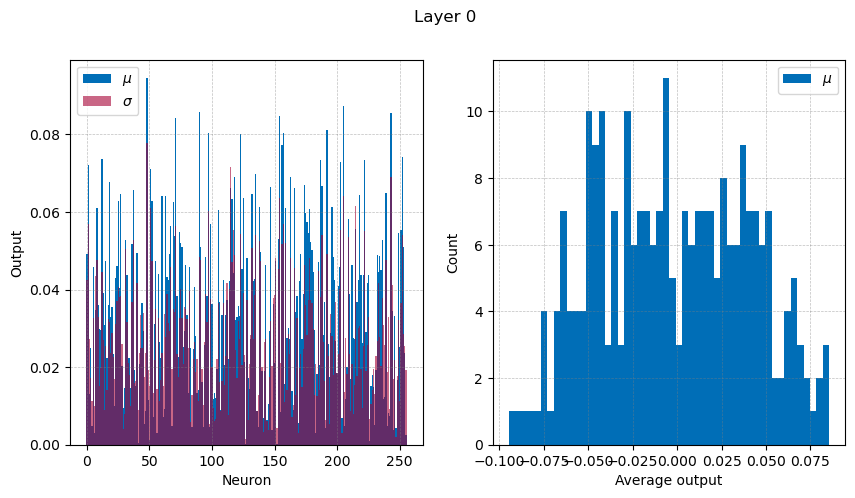

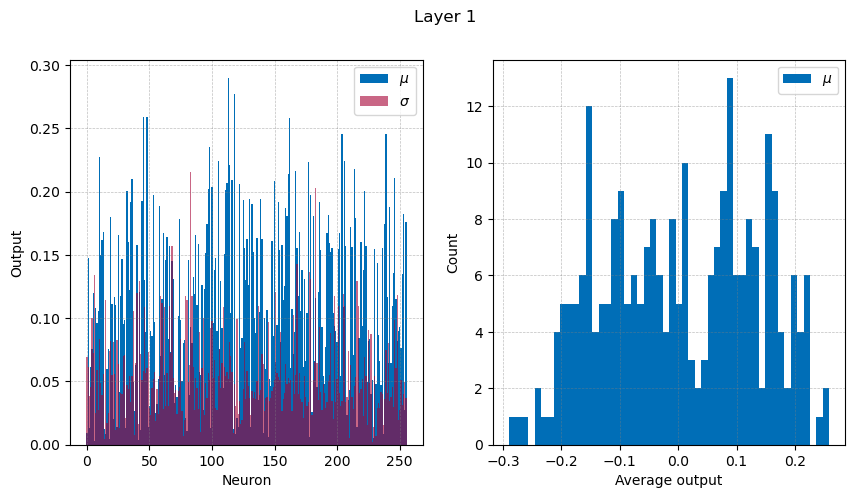

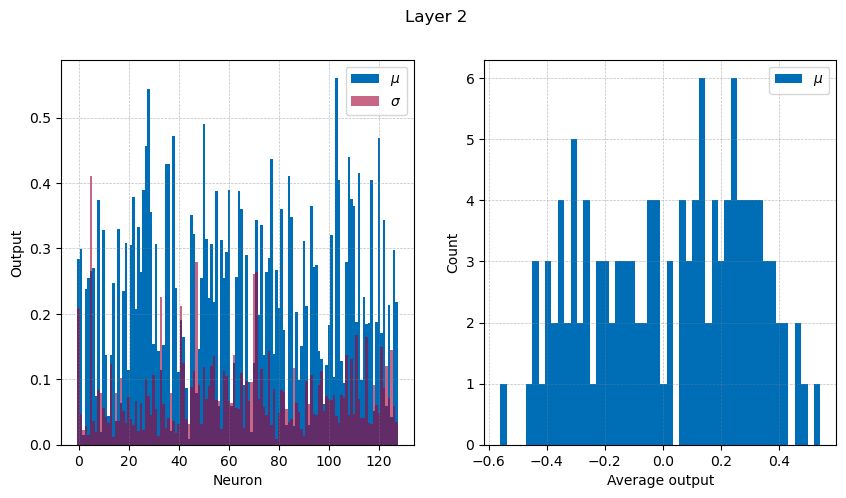

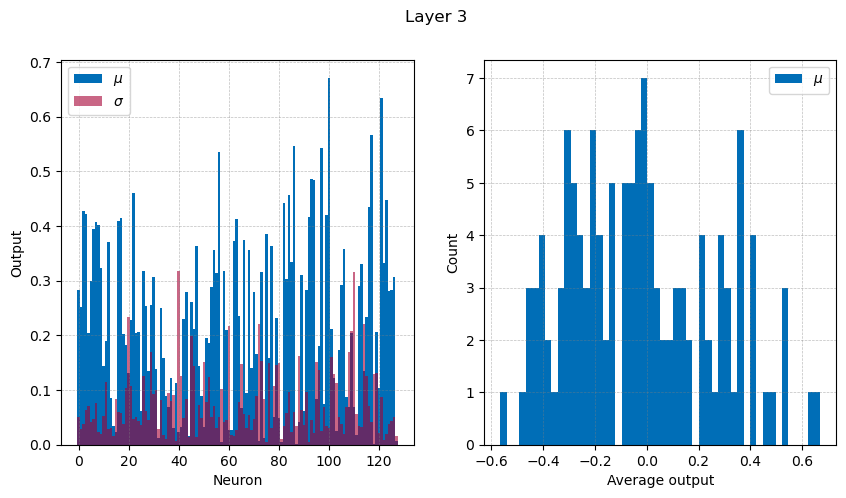

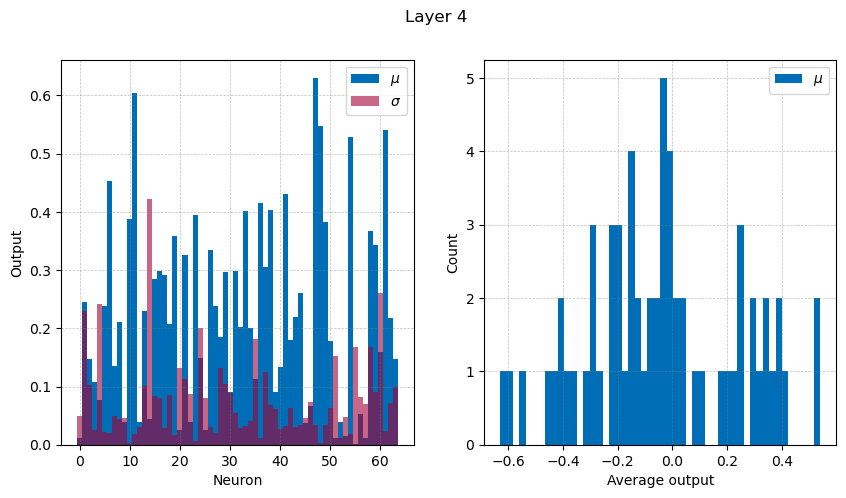

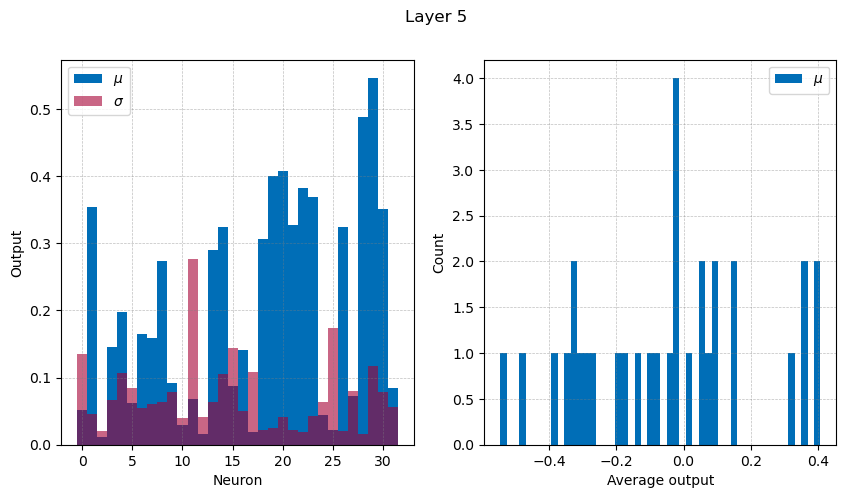

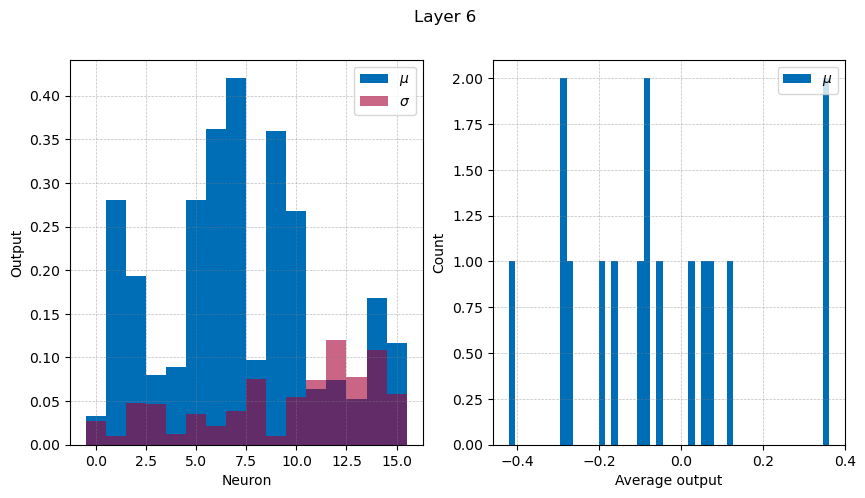

In [ ]:
for i, layer_output in enumerate(average_outputs):
    x = np.arange(layer_output.shape[0])
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].bar(x, np.abs(layer_output), color=plt_colors[0], width=1, label=r"$\mu$")
    ax[0].bar(x, std_outputs[i], color=plt_colors[1], width=1, alpha=0.6, label=r"$\sigma$")
    ax[0].set_xlabel("Neuron")
    ax[0].set_ylabel("Output")
    ax[0].legend()
    ax[0].grid()

    ax[1].hist(layer_output, bins=50, color=plt_colors[0], label=r"$\mu$")
    ax[1].set_xlabel("Average output")
    ax[1].set_ylabel("Count")
    ax[1].legend()
    ax[1].grid()

    plt.suptitle(f"Layer {i}")
    plt.show()